In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score

from transformers import AdamW

# from transformers import BertTokenizer, BertConfig
# from transformers import BertForTokenClassification, AdamW

# from transformers import RobertaConfig, RobertaModel
# from transformers import RobertaTokenizer, RobertaForTokenClassification, AutoTokenizer, AdamW

from transformers import AutoTokenizer, AlbertForTokenClassification

2023-07-24 10:05:05.819247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 10:05:06.358553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('dataset.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")


In [5]:
def degreekify(char):
    #char will be a character
    greek = {'α': '[alpha]', 'β':'[beta]', 'γ': '[gamma]', 'δ':'[delta]', 'ε': '[epsilon]', 'ζ':'[zeta]', 'η': '[eta]',
            'θ':'[theta]', 'ι': '[iota]', 'κ':'[kappa]', 'λ':'[lambda]', 'μ': '[mu]', 'ν':'[nu]', 'ξ':'[xi]', 'ο':'[omicron]', 'π':'[pi]', 'ρ':'[rho]',
            'σ': '[sigma]', 'τ': '[tau]', 'υ':'[upsilon]', 'φ':'[phi]', 'χ':'[chi]', 'ψ':'[psi]', 'ω':'[omega]' }
    if char in greek:
        return greek[char]
    else:
        return char

In [6]:
def pre_process(text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    text_dict = []
    
    for i in range(len(text)):
        text_dict.append(degreekify(text[i]))
    
    
    
    ann_indices = []
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    
    
    if len(annotations)==0:
        ann_indices.append([[0, len(text)],0])
    else:
        ann_indices.append([[0, annotations[0]['start_offset']], 0])
        for i in range(len(annotations)-1):
            ann_indices.append([[annotations[i]['start_offset'], annotations[i]['end_offset']], annotations[i]['label']])
            ann_indices.append([[annotations[i]['end_offset'], annotations[i+1]['start_offset']], 0])
            
        ann_indices.append([[annotations[-1]['start_offset'], annotations[-1]['end_offset']], annotations[-1]['label']])
        ann_indices.append([[annotations[-1]['end_offset'], len(text)], 0])
         
    
    labels = []
    sentences = []
    for a in ann_indices:
        
        if a[0][1]-a[0][0] !=0:
            together = ''
            for i in range(a[0][0], a[0][1]):
                together += text_dict[i]
                
            toke = together.split()
            sentences.extend(toke)
            t = len(toke)
            if t != 0:
                temp = [data_tags[2 * a[1]]] * t
                if a[1] != 0:
                    temp[0] = data_tags[2 * a[1]-1]
                labels.extend(temp)
 
    return labels, sentences

In [7]:
#create labels
data_tags = ['0','C', 'C-cont' , 'M', 'M-cont', 'Q', 'Q-cont', 'T' , 'T-cont', 'A' , 'A-cont', 'R', 'R-cont']

sentences, labels = [], []

for i in range(len(info)):
    l,s = pre_process(info[i]['text'], info[i]['annotations'])
    if len(l) != len(s):
        print('fuck')
    else:
        labels.append(l)
        sentences.append(s)

In [8]:

for i in range(5):
    s, l = sentences[i], labels[i]
    if len(l) != len(s):
        print('fuck')
    else:
        for j in range(len(l)):
            print(l[j],s[j])
    

0 The
0 influence
0 of
R [gamma]-radiation
0 on
0 the
0 physical
0 characteristics
0 and
0 sorption
0 properties
0 for
M Am
0 of
0 the
0 solid
0 extractant
C AXIONIT
C-cont MND
C-cont 40T
0 (
C TVEX
0 )
0 synthesized
0 by
0 Axion-Rare
0 and
0 Noble
0 Metals
0 JSC
0 (Perm)
0 was
0 studied.
0 With
0 an
0 increase
0 of
0 the
0 absorbed
0 dose
0 of
R [gamma]-radiation
0 ,
0 the
0 granulometric
0 composition,
0 bulk
0 density,
0 and
0 specific
0 volume
0 of
C TVEX
0 change
0 insignificantly.
0 The
0 IR
0 spectra
0 of
C TVEX
0 demonstrate
0 significant
0 radiation
0 degradation
0 at
0 an
0 absorbed
0 radiation
0 dose
0 from
Q 1.4
Q-cont to
Q-cont 2.5
Q-cont MGy
0 .
C TVEX
0 is
0 an
0 effective
M Am
0 sorbent
0 when
0 irradiated
0 to
0 an
0 absorbed
R [gamma]-radiation
0 dose
0 of
0 no
0 more
0 than
Q 0.6
Q-cont MGy
0 .
0 At
0 an
0 irradiation
0 dose
0 of
Q 2.5
Q-cont MGy
0 sorption
0 capacity
0 is
0 significantly
0 reduced.
0 Basic
0 physicochemical
0 properties
0 of
0 the
C TVEX
0 sample
0 

In [9]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont']
['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont', 'PAD']
{'0': 0, 'C': 1, 'C-cont': 2, 'M': 3, 'M-cont': 4, 'Q': 5, 'Q-cont': 6, 'T': 7, 'T-cont': 8, 'A': 9, 'A-cont': 10, 'R': 11, 'R-cont': 12, 'PAD': 13}


In [10]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [11]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [12]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 128 # 64 or 128 or ...
bs = 6 # batch size


In [13]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
     

In [14]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [15]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [16]:
# Load RoBERTa Model
from transformers import AutoTokenizer, AutoModelForTokenClassification
model = AlbertForTokenClassification.from_pretrained(
    "albert-base-v2",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
    
)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForTokenClassification: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

In [17]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [18]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 4e-6, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
epochs = 500

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=30,
    num_training_steps=total_steps
)

# **Training**

In [20]:
def acc(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sentences)):
       
        temp = []
        for j in range(len(sentences[i])):
            temp.extend(tokenizer.tokenize(sentences[i][j]))
        
        temp1 = []
     
        for j in range(len(temp)):
            t = tokenizer.convert_tokens_to_ids(temp[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, labels[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",labels[i])
            print()
            print()
            if special == i:
                for j in range(len(sentences[i])):
                    print(sentences[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [21]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

max_test = 10

for e in trange(epochs, desc="Epoch"):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = eval_loss
    test_acc.append(a)
    if a <= max_test:
        max_test = a
    elif a * 1.2 == max_test:
        f = open("text.ck", "w")
        torch.save(model, "test.ck")
        f.close()

Epoch:   0%|▍                                                                                                                                                                                                                                           | 1/500 [00:01<16:07,  1.94s/it]


Average train loss: 2.800799608230591

Validation loss: 2.1715166568756104
Validation Accuracy: 0.37555555555555553



Epoch:   0%|▉                                                                                                                                                                                                                                           | 2/500 [00:03<13:31,  1.63s/it]


Average train loss: 1.797552423477173

Validation loss: 1.527124007542928
Validation Accuracy: 0.6659259259259259



Epoch:   1%|█▍                                                                                                                                                                                                                                          | 3/500 [00:04<12:39,  1.53s/it]


Average train loss: 1.5035147619247438

Validation loss: 1.4324417114257812
Validation Accuracy: 0.6696296296296296



Epoch:   1%|█▉                                                                                                                                                                                                                                          | 4/500 [00:06<12:15,  1.48s/it]


Average train loss: 1.369723801612854

Validation loss: 1.3278172810872395
Validation Accuracy: 0.64



Epoch:   1%|██▎                                                                                                                                                                                                                                         | 5/500 [00:07<12:01,  1.46s/it]


Average train loss: 1.2393273138999938

Validation loss: 1.2155080636342366
Validation Accuracy: 0.5844444444444444



Epoch:   1%|██▊                                                                                                                                                                                                                                         | 6/500 [00:08<11:51,  1.44s/it]


Average train loss: 1.0714503526687622

Validation loss: 1.06941952308019
Validation Accuracy: 0.6370370370370371



Epoch:   1%|███▎                                                                                                                                                                                                                                        | 7/500 [00:10<11:46,  1.43s/it]


Average train loss: 0.9143192553520203

Validation loss: 0.9258046348889669
Validation Accuracy: 0.6718518518518518



Epoch:   2%|███▊                                                                                                                                                                                                                                        | 8/500 [00:11<11:42,  1.43s/it]


Average train loss: 0.7807844364643097

Validation loss: 0.8134888410568237
Validation Accuracy: 0.6911111111111111



Epoch:   2%|████▏                                                                                                                                                                                                                                       | 9/500 [00:13<11:39,  1.42s/it]


Average train loss: 0.6979427134990692

Validation loss: 0.7237656911214193
Validation Accuracy: 0.7244444444444444



Epoch:   2%|████▋                                                                                                                                                                                                                                      | 10/500 [00:14<11:36,  1.42s/it]


Average train loss: 0.6252043795585632

Validation loss: 0.6317276954650879
Validation Accuracy: 0.7488888888888889



Epoch:   2%|█████▏                                                                                                                                                                                                                                     | 11/500 [00:16<11:33,  1.42s/it]


Average train loss: 0.5605408608913421

Validation loss: 0.6155131856600443
Validation Accuracy: 0.7555555555555555



Epoch:   2%|█████▋                                                                                                                                                                                                                                     | 12/500 [00:17<11:31,  1.42s/it]


Average train loss: 0.4897744905948639

Validation loss: 0.6220880647500356
Validation Accuracy: 0.7622222222222222



Epoch:   3%|██████                                                                                                                                                                                                                                     | 13/500 [00:18<11:28,  1.41s/it]


Average train loss: 0.44090824961662295

Validation loss: 0.5815864702065786
Validation Accuracy: 0.7681481481481481



Epoch:   3%|██████▌                                                                                                                                                                                                                                    | 14/500 [00:20<11:24,  1.41s/it]


Average train loss: 0.4078829491138458

Validation loss: 0.5762619276841482
Validation Accuracy: 0.7688888888888888



Epoch:   3%|███████                                                                                                                                                                                                                                    | 15/500 [00:21<11:22,  1.41s/it]


Average train loss: 0.3633453506231308

Validation loss: 0.5784092048803965
Validation Accuracy: 0.7777777777777778



Epoch:   3%|███████▌                                                                                                                                                                                                                                   | 16/500 [00:23<11:20,  1.41s/it]


Average train loss: 0.3347805976867676

Validation loss: 0.5658537646134695
Validation Accuracy: 0.7851851851851852



Epoch:   3%|███████▉                                                                                                                                                                                                                                   | 17/500 [00:24<11:20,  1.41s/it]


Average train loss: 0.30208987593650816

Validation loss: 0.6070590019226074
Validation Accuracy: 0.7814814814814814



Epoch:   4%|████████▍                                                                                                                                                                                                                                  | 18/500 [00:25<11:20,  1.41s/it]


Average train loss: 0.2827083241939545

Validation loss: 0.5564287602901459
Validation Accuracy: 0.7911111111111111



Epoch:   4%|████████▉                                                                                                                                                                                                                                  | 19/500 [00:27<11:20,  1.42s/it]


Average train loss: 0.25923757165670397

Validation loss: 0.5412672559420267
Validation Accuracy: 0.7948148148148149



Epoch:   4%|█████████▍                                                                                                                                                                                                                                 | 20/500 [00:28<11:19,  1.41s/it]


Average train loss: 0.23747287571430206

Validation loss: 0.6043943067391714
Validation Accuracy: 0.7985185185185185



Epoch:   4%|█████████▊                                                                                                                                                                                                                                 | 21/500 [00:30<11:18,  1.42s/it]


Average train loss: 0.2222812733054161

Validation loss: 0.5447370310624441
Validation Accuracy: 0.8088888888888889



Epoch:   4%|██████████▎                                                                                                                                                                                                                                | 22/500 [00:31<11:18,  1.42s/it]


Average train loss: 0.2024802166223526

Validation loss: 0.5587717890739441
Validation Accuracy: 0.8074074074074075



Epoch:   5%|██████████▊                                                                                                                                                                                                                                | 23/500 [00:33<11:17,  1.42s/it]


Average train loss: 0.18234027355909346

Validation loss: 0.5535828769207001
Validation Accuracy: 0.8051851851851852



Epoch:   5%|███████████▎                                                                                                                                                                                                                               | 24/500 [00:34<11:15,  1.42s/it]


Average train loss: 0.177158185839653

Validation loss: 0.5843518972396851
Validation Accuracy: 0.8111111111111111



Epoch:   5%|███████████▊                                                                                                                                                                                                                               | 25/500 [00:35<11:15,  1.42s/it]


Average train loss: 0.1606559455394745

Validation loss: 0.5410084625085195
Validation Accuracy: 0.8037037037037037



Epoch:   5%|████████████▏                                                                                                                                                                                                                              | 26/500 [00:37<11:13,  1.42s/it]


Average train loss: 0.14970050156116485

Validation loss: 0.6149312357107798
Validation Accuracy: 0.8155555555555556



Epoch:   5%|████████████▋                                                                                                                                                                                                                              | 27/500 [00:38<11:13,  1.42s/it]


Average train loss: 0.13005797524005175

Validation loss: 0.6154959400494894
Validation Accuracy: 0.8177777777777778



Epoch:   6%|█████████████▏                                                                                                                                                                                                                             | 28/500 [00:40<11:13,  1.43s/it]


Average train loss: 0.12230373412370682

Validation loss: 0.5795712868372599
Validation Accuracy: 0.8207407407407408



Epoch:   6%|█████████████▋                                                                                                                                                                                                                             | 29/500 [00:41<11:11,  1.43s/it]


Average train loss: 0.11829214408993721

Validation loss: 0.5581949651241302
Validation Accuracy: 0.8125925925925926



Epoch:   6%|██████████████                                                                                                                                                                                                                             | 30/500 [00:43<11:10,  1.43s/it]


Average train loss: 0.10633262336254119

Validation loss: 0.5880259275436401
Validation Accuracy: 0.8177777777777778



Epoch:   6%|██████████████▌                                                                                                                                                                                                                            | 31/500 [00:44<11:09,  1.43s/it]


Average train loss: 0.09168116917833685

Validation loss: 0.5763143301010132
Validation Accuracy: 0.8296296296296296



Epoch:   6%|███████████████                                                                                                                                                                                                                            | 32/500 [00:45<11:07,  1.43s/it]


Average train loss: 0.09078107386827469

Validation loss: 0.513219396273295
Validation Accuracy: 0.8333333333333334



Epoch:   7%|███████████████▌                                                                                                                                                                                                                           | 33/500 [00:47<11:05,  1.42s/it]


Average train loss: 0.08086690694093704

Validation loss: 0.5377662082513174
Validation Accuracy: 0.8274074074074074



Epoch:   7%|███████████████▉                                                                                                                                                                                                                           | 34/500 [00:48<11:03,  1.42s/it]


Average train loss: 0.07948369204998017

Validation loss: 0.53492538134257
Validation Accuracy: 0.8362962962962963



Epoch:   7%|████████████████▍                                                                                                                                                                                                                          | 35/500 [00:50<11:03,  1.43s/it]


Average train loss: 0.06812116879038513

Validation loss: 0.6256489157676697
Validation Accuracy: 0.8429629629629629



Epoch:   7%|████████████████▉                                                                                                                                                                                                                          | 36/500 [00:51<11:01,  1.43s/it]


Average train loss: 0.06467165090143681

Validation loss: 0.5300913254419962
Validation Accuracy: 0.8451851851851852



Epoch:   7%|█████████████████▍                                                                                                                                                                                                                         | 37/500 [00:52<11:00,  1.43s/it]


Average train loss: 0.06726304091513156

Validation loss: 0.5516617397467295
Validation Accuracy: 0.8318518518518518



Epoch:   8%|█████████████████▊                                                                                                                                                                                                                         | 38/500 [00:54<10:58,  1.43s/it]


Average train loss: 0.059040671810507775

Validation loss: 0.5996446510155996
Validation Accuracy: 0.8451851851851852



Epoch:   8%|██████████████████▎                                                                                                                                                                                                                        | 39/500 [00:55<10:58,  1.43s/it]


Average train loss: 0.051051633059978486

Validation loss: 0.518921305735906
Validation Accuracy: 0.8488888888888889



Epoch:   8%|██████████████████▊                                                                                                                                                                                                                        | 40/500 [00:57<10:57,  1.43s/it]


Average train loss: 0.048260141313076016

Validation loss: 0.5970652401447296
Validation Accuracy: 0.8414814814814815



Epoch:   8%|███████████████████▎                                                                                                                                                                                                                       | 41/500 [00:58<10:56,  1.43s/it]


Average train loss: 0.04379992762580514

Validation loss: 0.5304669737815857
Validation Accuracy: 0.8429629629629629



Epoch:   8%|███████████████████▋                                                                                                                                                                                                                       | 42/500 [01:00<10:55,  1.43s/it]


Average train loss: 0.040416325964033606

Validation loss: 0.494648019472758
Validation Accuracy: 0.8392592592592593



Epoch:   9%|████████████████████▏                                                                                                                                                                                                                      | 43/500 [01:01<10:54,  1.43s/it]


Average train loss: 0.03817835416644812

Validation loss: 0.5293217400709788
Validation Accuracy: 0.8451851851851852



Epoch:   9%|████████████████████▋                                                                                                                                                                                                                      | 44/500 [01:03<10:53,  1.43s/it]


Average train loss: 0.03418447711970657

Validation loss: 0.4520951559146245
Validation Accuracy: 0.8488888888888889



Epoch:   9%|█████████████████████▏                                                                                                                                                                                                                     | 45/500 [01:04<10:51,  1.43s/it]


Average train loss: 0.03202822532504797

Validation loss: 0.48699845870335895
Validation Accuracy: 0.8511111111111112



Epoch:   9%|█████████████████████▌                                                                                                                                                                                                                     | 46/500 [01:05<10:50,  1.43s/it]


Average train loss: 0.029956184532493352

Validation loss: 0.5122298995653788
Validation Accuracy: 0.8577777777777778



Epoch:   9%|██████████████████████                                                                                                                                                                                                                     | 47/500 [01:07<10:49,  1.43s/it]


Average train loss: 0.027194806039333344

Validation loss: 0.47258300085862476
Validation Accuracy: 0.8474074074074074



Epoch:  10%|██████████████████████▌                                                                                                                                                                                                                    | 48/500 [01:08<10:48,  1.43s/it]


Average train loss: 0.027356514409184456

Validation loss: 0.476227343082428
Validation Accuracy: 0.8503703703703703



Epoch:  10%|███████████████████████                                                                                                                                                                                                                    | 49/500 [01:10<10:46,  1.43s/it]


Average train loss: 0.02367515940219164

Validation loss: 0.5182183782259623
Validation Accuracy: 0.8444444444444444



Epoch:  10%|███████████████████████▌                                                                                                                                                                                                                   | 50/500 [01:11<10:46,  1.44s/it]


Average train loss: 0.02109249323606491

Validation loss: 0.5737170974413554
Validation Accuracy: 0.8444444444444444



Epoch:  10%|███████████████████████▉                                                                                                                                                                                                                   | 51/500 [01:13<10:45,  1.44s/it]


Average train loss: 0.022379249539226292

Validation loss: 0.45712381104628247
Validation Accuracy: 0.8577777777777778



Epoch:  10%|████████████████████████▍                                                                                                                                                                                                                  | 52/500 [01:14<10:43,  1.44s/it]


Average train loss: 0.018907686099410057

Validation loss: 0.5244784007469813
Validation Accuracy: 0.8414814814814815



Epoch:  11%|████████████████████████▉                                                                                                                                                                                                                  | 53/500 [01:15<10:42,  1.44s/it]


Average train loss: 0.01960858128964901

Validation loss: 0.5447931885719299
Validation Accuracy: 0.8511111111111112



Epoch:  11%|█████████████████████████▍                                                                                                                                                                                                                 | 54/500 [01:17<10:40,  1.44s/it]


Average train loss: 0.016697008349001407

Validation loss: 0.5314409881830215
Validation Accuracy: 0.8622222222222222



Epoch:  11%|█████████████████████████▊                                                                                                                                                                                                                 | 55/500 [01:18<10:40,  1.44s/it]


Average train loss: 0.014907134156674147

Validation loss: 0.5138147175312042
Validation Accuracy: 0.8525925925925926



Epoch:  11%|██████████████████████████▎                                                                                                                                                                                                                | 56/500 [01:20<10:38,  1.44s/it]


Average train loss: 0.014235654454678297

Validation loss: 0.5153293112913767
Validation Accuracy: 0.8503703703703703



Epoch:  11%|██████████████████████████▊                                                                                                                                                                                                                | 57/500 [01:21<10:37,  1.44s/it]


Average train loss: 0.016950902845710516

Validation loss: 0.5562617480754852
Validation Accuracy: 0.8540740740740741



Epoch:  12%|███████████████████████████▎                                                                                                                                                                                                               | 58/500 [01:23<10:35,  1.44s/it]


Average train loss: 0.01095991162583232

Validation loss: 0.5335739503304163
Validation Accuracy: 0.8533333333333334



Epoch:  12%|███████████████████████████▋                                                                                                                                                                                                               | 59/500 [01:24<10:34,  1.44s/it]


Average train loss: 0.011219164971262217

Validation loss: 0.5566428005695343
Validation Accuracy: 0.8548148148148148



Epoch:  12%|████████████████████████████▏                                                                                                                                                                                                              | 60/500 [01:26<10:32,  1.44s/it]


Average train loss: 0.009485470433719456

Validation loss: 0.5581346750259399
Validation Accuracy: 0.8651851851851852



Epoch:  12%|████████████████████████████▋                                                                                                                                                                                                              | 61/500 [01:27<10:31,  1.44s/it]


Average train loss: 0.008732981756329536

Validation loss: 0.5451427847146988
Validation Accuracy: 0.8437037037037037



Epoch:  12%|█████████████████████████████▏                                                                                                                                                                                                             | 62/500 [01:28<10:29,  1.44s/it]


Average train loss: 0.009123099185526371

Validation loss: 0.5838108956813812
Validation Accuracy: 0.8540740740740741



Epoch:  13%|█████████████████████████████▌                                                                                                                                                                                                             | 63/500 [01:30<10:28,  1.44s/it]


Average train loss: 0.008381560416892172

Validation loss: 0.5729077359040579
Validation Accuracy: 0.8555555555555555



Epoch:  13%|██████████████████████████████                                                                                                                                                                                                             | 64/500 [01:31<10:26,  1.44s/it]


Average train loss: 0.007465299591422081

Validation loss: 0.5285795529683431
Validation Accuracy: 0.8555555555555555



Epoch:  13%|██████████████████████████████▌                                                                                                                                                                                                            | 65/500 [01:33<10:25,  1.44s/it]


Average train loss: 0.006574309207499027

Validation loss: 0.5529426485300064
Validation Accuracy: 0.8562962962962963



Epoch:  13%|███████████████████████████████                                                                                                                                                                                                            | 66/500 [01:34<10:24,  1.44s/it]


Average train loss: 0.006727373851463199

Validation loss: 0.5680798639853796
Validation Accuracy: 0.8533333333333334



Epoch:  13%|███████████████████████████████▍                                                                                                                                                                                                           | 67/500 [01:36<10:23,  1.44s/it]


Average train loss: 0.00652351529803127

Validation loss: 0.5856477320194244
Validation Accuracy: 0.8548148148148148



Epoch:  14%|███████████████████████████████▉                                                                                                                                                                                                           | 68/500 [01:37<10:21,  1.44s/it]


Average train loss: 0.005085492776706815

Validation loss: 0.5509953697522482
Validation Accuracy: 0.8622222222222222



Epoch:  14%|████████████████████████████████▍                                                                                                                                                                                                          | 69/500 [01:38<10:19,  1.44s/it]


Average train loss: 0.00502171347849071

Validation loss: 0.5550529807806015
Validation Accuracy: 0.8614814814814815



Epoch:  14%|████████████████████████████████▉                                                                                                                                                                                                          | 70/500 [01:40<10:18,  1.44s/it]


Average train loss: 0.0049080861546099185

Validation loss: 0.5644815961519877
Validation Accuracy: 0.8533333333333334



Epoch:  14%|█████████████████████████████████▎                                                                                                                                                                                                         | 71/500 [01:41<10:17,  1.44s/it]


Average train loss: 0.004895506286993622

Validation loss: 0.6074507286151251
Validation Accuracy: 0.8533333333333334



Epoch:  14%|█████████████████████████████████▊                                                                                                                                                                                                         | 72/500 [01:43<10:16,  1.44s/it]


Average train loss: 0.004600161875132471

Validation loss: 0.553785706559817
Validation Accuracy: 0.8577777777777778



Epoch:  15%|██████████████████████████████████▎                                                                                                                                                                                                        | 73/500 [01:44<10:14,  1.44s/it]


Average train loss: 0.004369856459088623

Validation loss: 0.5859543432792028
Validation Accuracy: 0.8644444444444445



Epoch:  15%|██████████████████████████████████▊                                                                                                                                                                                                        | 74/500 [01:46<10:13,  1.44s/it]


Average train loss: 0.0046880994271486995

Validation loss: 0.6125359137852987
Validation Accuracy: 0.8637037037037038



Epoch:  15%|███████████████████████████████████▎                                                                                                                                                                                                       | 75/500 [01:47<10:12,  1.44s/it]


Average train loss: 0.003976346044801175

Validation loss: 0.5680527091026306
Validation Accuracy: 0.857037037037037



Epoch:  15%|███████████████████████████████████▋                                                                                                                                                                                                       | 76/500 [01:49<10:10,  1.44s/it]


Average train loss: 0.004361430257558823

Validation loss: 0.5963248014450073
Validation Accuracy: 0.857037037037037



Epoch:  15%|████████████████████████████████████▏                                                                                                                                                                                                      | 77/500 [01:50<10:09,  1.44s/it]


Average train loss: 0.003040974989999086

Validation loss: 0.5350077797969183
Validation Accuracy: 0.8592592592592593



Epoch:  16%|████████████████████████████████████▋                                                                                                                                                                                                      | 78/500 [01:51<10:07,  1.44s/it]


Average train loss: 0.003001634324900806

Validation loss: 0.5819975088040034
Validation Accuracy: 0.8562962962962963



Epoch:  16%|█████████████████████████████████████▏                                                                                                                                                                                                     | 79/500 [01:53<10:06,  1.44s/it]


Average train loss: 0.003555173547938466

Validation loss: 0.5686718622843424
Validation Accuracy: 0.8577777777777778



Epoch:  16%|█████████████████████████████████████▌                                                                                                                                                                                                     | 80/500 [01:54<10:05,  1.44s/it]


Average train loss: 0.0029643947631120683

Validation loss: 0.6376452147960663
Validation Accuracy: 0.8533333333333334



Epoch:  16%|██████████████████████████████████████                                                                                                                                                                                                     | 81/500 [01:56<10:03,  1.44s/it]


Average train loss: 0.002926662036916241

Validation loss: 0.5388826181491216
Validation Accuracy: 0.8577777777777778



Epoch:  16%|██████████████████████████████████████▌                                                                                                                                                                                                    | 82/500 [01:57<10:00,  1.44s/it]


Average train loss: 0.003731437539681792

Validation loss: 0.5746433287858963
Validation Accuracy: 0.8585185185185186



Epoch:  17%|███████████████████████████████████████                                                                                                                                                                                                    | 83/500 [01:59<09:57,  1.43s/it]


Average train loss: 0.002353206598199904

Validation loss: 0.5675985167423884
Validation Accuracy: 0.8562962962962963



Epoch:  17%|███████████████████████████████████████▍                                                                                                                                                                                                   | 84/500 [02:00<09:54,  1.43s/it]


Average train loss: 0.003291489437688142

Validation loss: 0.5928608377774557
Validation Accuracy: 0.8659259259259259



Epoch:  17%|███████████████████████████████████████▉                                                                                                                                                                                                   | 85/500 [02:01<09:52,  1.43s/it]


Average train loss: 0.0025085019669495523

Validation loss: 0.5473053256670634
Validation Accuracy: 0.8659259259259259



Epoch:  17%|████████████████████████████████████████▍                                                                                                                                                                                                  | 86/500 [02:03<09:50,  1.43s/it]


Average train loss: 0.001868476434610784

Validation loss: 0.5844378024339676
Validation Accuracy: 0.8577777777777778



Epoch:  17%|████████████████████████████████████████▉                                                                                                                                                                                                  | 87/500 [02:04<09:48,  1.42s/it]


Average train loss: 0.0016912921390030533

Validation loss: 0.5925605098406473
Validation Accuracy: 0.8681481481481481



Epoch:  18%|█████████████████████████████████████████▎                                                                                                                                                                                                 | 88/500 [02:06<09:46,  1.42s/it]


Average train loss: 0.0035097034217324106

Validation loss: 0.5488116343816122
Validation Accuracy: 0.8548148148148148



Epoch:  18%|█████████████████████████████████████████▊                                                                                                                                                                                                 | 89/500 [02:07<09:45,  1.42s/it]


Average train loss: 0.0018417659390252083

Validation loss: 0.5722703089316686
Validation Accuracy: 0.8637037037037038



Epoch:  18%|██████████████████████████████████████████▎                                                                                                                                                                                                | 90/500 [02:09<09:43,  1.42s/it]


Average train loss: 0.0018037294130772352

Validation loss: 0.5740253378947576
Validation Accuracy: 0.8577777777777778



Epoch:  18%|██████████████████████████████████████████▊                                                                                                                                                                                                | 91/500 [02:10<09:41,  1.42s/it]


Average train loss: 0.0021007013542111964

Validation loss: 0.574321468671163
Validation Accuracy: 0.8577777777777778



Epoch:  18%|███████████████████████████████████████████▏                                                                                                                                                                                               | 92/500 [02:11<09:40,  1.42s/it]


Average train loss: 0.0017105886049102992

Validation loss: 0.5558263063430786
Validation Accuracy: 0.8592592592592593



Epoch:  19%|███████████████████████████████████████████▋                                                                                                                                                                                               | 93/500 [02:13<09:39,  1.42s/it]


Average train loss: 0.0019819730415474622

Validation loss: 0.5985989520947138
Validation Accuracy: 0.8592592592592593



Epoch:  19%|████████████████████████████████████████████▏                                                                                                                                                                                              | 94/500 [02:14<09:37,  1.42s/it]


Average train loss: 0.0017758782859891653

Validation loss: 0.5533628016710281
Validation Accuracy: 0.8666666666666667



Epoch:  19%|████████████████████████████████████████████▋                                                                                                                                                                                              | 95/500 [02:16<09:36,  1.42s/it]


Average train loss: 0.0017077235598117113

Validation loss: 0.6089512705802917
Validation Accuracy: 0.8562962962962963



Epoch:  19%|█████████████████████████████████████████████                                                                                                                                                                                              | 96/500 [02:17<09:34,  1.42s/it]


Average train loss: 0.0014621353335678578

Validation loss: 0.6268325299024582
Validation Accuracy: 0.8629629629629629



Epoch:  19%|█████████████████████████████████████████████▌                                                                                                                                                                                             | 97/500 [02:19<09:33,  1.42s/it]


Average train loss: 0.0014087474974803626

Validation loss: 0.5945206085840861
Validation Accuracy: 0.8659259259259259



Epoch:  20%|██████████████████████████████████████████████                                                                                                                                                                                             | 98/500 [02:20<09:32,  1.42s/it]


Average train loss: 0.0015241858083754778

Validation loss: 0.6295466274023056
Validation Accuracy: 0.8592592592592593



Epoch:  20%|██████████████████████████████████████████████▌                                                                                                                                                                                            | 99/500 [02:21<09:30,  1.42s/it]


Average train loss: 0.0013095209328457713

Validation loss: 0.6534082293510437
Validation Accuracy: 0.8644444444444445



Epoch:  20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 100/500 [02:23<09:29,  1.42s/it]


Average train loss: 0.001342022483004257

Validation loss: 0.5912055025498072
Validation Accuracy: 0.8688888888888889



Epoch:  20%|███████████████████████████████████████████████▎                                                                                                                                                                                          | 101/500 [02:24<09:27,  1.42s/it]


Average train loss: 0.001137082721106708

Validation loss: 0.5831715514262518
Validation Accuracy: 0.8614814814814815



Epoch:  20%|███████████████████████████████████████████████▋                                                                                                                                                                                          | 102/500 [02:26<09:26,  1.42s/it]


Average train loss: 0.0010009692877065391

Validation loss: 0.6102216442426046
Validation Accuracy: 0.8674074074074074



Epoch:  21%|████████████████████████████████████████████████▏                                                                                                                                                                                         | 103/500 [02:27<09:24,  1.42s/it]


Average train loss: 0.0009352337021846324

Validation loss: 0.5937779396772385
Validation Accuracy: 0.8614814814814815



Epoch:  21%|████████████████████████████████████████████████▋                                                                                                                                                                                         | 104/500 [02:28<09:23,  1.42s/it]


Average train loss: 0.0010123256163205952

Validation loss: 0.6142301907142004
Validation Accuracy: 0.8614814814814815



Epoch:  21%|█████████████████████████████████████████████████▏                                                                                                                                                                                        | 105/500 [02:30<09:22,  1.42s/it]


Average train loss: 0.0010764655587263406

Validation loss: 0.6309328824281693
Validation Accuracy: 0.8659259259259259



Epoch:  21%|█████████████████████████████████████████████████▌                                                                                                                                                                                        | 106/500 [02:31<09:22,  1.43s/it]


Average train loss: 0.0008640566689427942

Validation loss: 0.5727118253707886
Validation Accuracy: 0.8674074074074074



Epoch:  21%|██████████████████████████████████████████████████                                                                                                                                                                                        | 107/500 [02:33<09:22,  1.43s/it]


Average train loss: 0.0007887378078885376

Validation loss: 0.5921391646067301
Validation Accuracy: 0.86



Epoch:  22%|██████████████████████████████████████████████████▌                                                                                                                                                                                       | 108/500 [02:34<09:22,  1.43s/it]


Average train loss: 0.0008586696139536798

Validation loss: 0.6208123564720154
Validation Accuracy: 0.8637037037037038



Epoch:  22%|███████████████████████████████████████████████████                                                                                                                                                                                       | 109/500 [02:36<09:21,  1.44s/it]


Average train loss: 0.0007818416436202824

Validation loss: 0.6289878338575363
Validation Accuracy: 0.8577777777777778



Epoch:  22%|███████████████████████████████████████████████████▍                                                                                                                                                                                      | 110/500 [02:37<09:20,  1.44s/it]


Average train loss: 0.0007108858693391085

Validation loss: 0.6686584949493408
Validation Accuracy: 0.8681481481481481



Epoch:  22%|███████████████████████████████████████████████████▉                                                                                                                                                                                      | 111/500 [02:39<09:19,  1.44s/it]


Average train loss: 0.0009390285424888134

Validation loss: 0.5985894153515497
Validation Accuracy: 0.8592592592592593



Epoch:  22%|████████████████████████████████████████████████████▍                                                                                                                                                                                     | 112/500 [02:40<09:17,  1.44s/it]


Average train loss: 0.0011742435989435763

Validation loss: 0.6112173547347387
Validation Accuracy: 0.8696296296296296



Epoch:  23%|████████████████████████████████████████████████████▉                                                                                                                                                                                     | 113/500 [02:41<09:16,  1.44s/it]


Average train loss: 0.0007264791597845033

Validation loss: 0.6014537463585535
Validation Accuracy: 0.8637037037037038



Epoch:  23%|█████████████████████████████████████████████████████▎                                                                                                                                                                                    | 114/500 [02:43<09:15,  1.44s/it]


Average train loss: 0.0006301389005966485

Validation loss: 0.6207360476255417
Validation Accuracy: 0.8637037037037038



Epoch:  23%|█████████████████████████████████████████████████████▊                                                                                                                                                                                    | 115/500 [02:44<09:14,  1.44s/it]


Average train loss: 0.0007024649961385876

Validation loss: 0.6154862443606058
Validation Accuracy: 0.8637037037037038



Epoch:  23%|██████████████████████████████████████████████████████▎                                                                                                                                                                                   | 116/500 [02:46<09:12,  1.44s/it]


Average train loss: 0.0005651226284680888

Validation loss: 0.6459708462158839
Validation Accuracy: 0.8666666666666667



Epoch:  23%|██████████████████████████████████████████████████████▊                                                                                                                                                                                   | 117/500 [02:47<09:11,  1.44s/it]


Average train loss: 0.000567684315610677

Validation loss: 0.6247519900401434
Validation Accuracy: 0.8651851851851852



Epoch:  24%|███████████████████████████████████████████████████████▏                                                                                                                                                                                  | 118/500 [02:49<09:10,  1.44s/it]


Average train loss: 0.0007235866383416578

Validation loss: 0.6564958542585373
Validation Accuracy: 0.8755555555555555



Epoch:  24%|███████████████████████████████████████████████████████▋                                                                                                                                                                                  | 119/500 [02:50<09:08,  1.44s/it]


Average train loss: 0.0005638032068964094

Validation loss: 0.6405833214521408
Validation Accuracy: 0.8592592592592593



Epoch:  24%|████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 120/500 [02:51<09:07,  1.44s/it]


Average train loss: 0.0004988627217244357

Validation loss: 0.6221636285384496
Validation Accuracy: 0.8666666666666667



Epoch:  24%|████████████████████████████████████████████████████████▋                                                                                                                                                                                 | 121/500 [02:53<09:06,  1.44s/it]


Average train loss: 0.0004412199335638434

Validation loss: 0.6343464801708857
Validation Accuracy: 0.8629629629629629



Epoch:  24%|█████████████████████████████████████████████████████████                                                                                                                                                                                 | 122/500 [02:54<09:04,  1.44s/it]


Average train loss: 0.0004096807102905586

Validation loss: 0.6434950083494186
Validation Accuracy: 0.8637037037037038



Epoch:  25%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                | 123/500 [02:56<09:02,  1.44s/it]


Average train loss: 0.0004044041212182492

Validation loss: 0.6436170687278112
Validation Accuracy: 0.8659259259259259



Epoch:  25%|██████████████████████████████████████████████████████████                                                                                                                                                                                | 124/500 [02:57<09:01,  1.44s/it]


Average train loss: 0.0003918342647375539

Validation loss: 0.6445362418889999
Validation Accuracy: 0.8637037037037038



Epoch:  25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 125/500 [02:59<08:59,  1.44s/it]


Average train loss: 0.00038029927702154965

Validation loss: 0.6485126415888468
Validation Accuracy: 0.8644444444444445



Epoch:  25%|██████████████████████████████████████████████████████████▉                                                                                                                                                                               | 126/500 [03:00<08:58,  1.44s/it]


Average train loss: 0.00037274003436323257

Validation loss: 0.6505201607942581
Validation Accuracy: 0.8629629629629629



Epoch:  25%|███████████████████████████████████████████████████████████▍                                                                                                                                                                              | 127/500 [03:02<08:57,  1.44s/it]


Average train loss: 0.00036897754936944695

Validation loss: 0.649695947766304
Validation Accuracy: 0.8614814814814815



Epoch:  26%|███████████████████████████████████████████████████████████▉                                                                                                                                                                              | 128/500 [03:03<08:56,  1.44s/it]


Average train loss: 0.0003602351085282862

Validation loss: 0.6588743180036545
Validation Accuracy: 0.8644444444444445



Epoch:  26%|████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 129/500 [03:04<08:54,  1.44s/it]


Average train loss: 0.0003581497695995495

Validation loss: 0.6557298302650452
Validation Accuracy: 0.8644444444444445



Epoch:  26%|████████████████████████████████████████████████████████████▊                                                                                                                                                                             | 130/500 [03:06<08:53,  1.44s/it]


Average train loss: 0.0003304332838160917

Validation loss: 0.6599726478258768
Validation Accuracy: 0.8637037037037038



Epoch:  26%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                            | 131/500 [03:07<08:51,  1.44s/it]


Average train loss: 0.0003421618789434433

Validation loss: 0.6671899209419886
Validation Accuracy: 0.8637037037037038



Epoch:  26%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 132/500 [03:09<08:50,  1.44s/it]


Average train loss: 0.0003208727494347841

Validation loss: 0.6654937714338303
Validation Accuracy: 0.8629629629629629



Epoch:  27%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 133/500 [03:10<08:48,  1.44s/it]


Average train loss: 0.0003122329741017893

Validation loss: 0.6700717061758041
Validation Accuracy: 0.8637037037037038



Epoch:  27%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 134/500 [03:12<08:47,  1.44s/it]


Average train loss: 0.0003036707709543407

Validation loss: 0.6715437769889832
Validation Accuracy: 0.8629629629629629



Epoch:  27%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 135/500 [03:13<08:46,  1.44s/it]


Average train loss: 0.0003047407901613042

Validation loss: 0.6743326038122177
Validation Accuracy: 0.8629629629629629



Epoch:  27%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 136/500 [03:15<08:44,  1.44s/it]


Average train loss: 0.00029806068050675094

Validation loss: 0.6762458930412928
Validation Accuracy: 0.8629629629629629



Epoch:  27%|████████████████████████████████████████████████████████████████                                                                                                                                                                          | 137/500 [03:16<08:42,  1.44s/it]


Average train loss: 0.00029230609245132653

Validation loss: 0.6776637683312098
Validation Accuracy: 0.8629629629629629



Epoch:  28%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 138/500 [03:17<08:41,  1.44s/it]


Average train loss: 0.00028412312211003156

Validation loss: 0.681954026222229
Validation Accuracy: 0.8637037037037038



Epoch:  28%|█████████████████████████████████████████████████████████████████                                                                                                                                                                         | 139/500 [03:19<08:40,  1.44s/it]


Average train loss: 0.00027872041624505073

Validation loss: 0.6835150172313055
Validation Accuracy: 0.8629629629629629



Epoch:  28%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 140/500 [03:20<08:39,  1.44s/it]


Average train loss: 0.00027133850322570653

Validation loss: 0.6842102259397507
Validation Accuracy: 0.8644444444444445



Epoch:  28%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 141/500 [03:22<08:37,  1.44s/it]


Average train loss: 0.0002687402383890003

Validation loss: 0.6856575161218643
Validation Accuracy: 0.8644444444444445



Epoch:  28%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                                       | 142/500 [03:23<08:35,  1.44s/it]


Average train loss: 0.0002683523710584268

Validation loss: 0.689603254199028
Validation Accuracy: 0.8644444444444445



Epoch:  29%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 143/500 [03:25<08:34,  1.44s/it]


Average train loss: 0.00026735144725535063

Validation loss: 0.6906451334555944
Validation Accuracy: 0.8644444444444445



Epoch:  29%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 144/500 [03:26<08:32,  1.44s/it]


Average train loss: 0.0002518726422567852

Validation loss: 0.6914507349332174
Validation Accuracy: 0.8651851851851852



Epoch:  29%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 145/500 [03:28<08:31,  1.44s/it]


Average train loss: 0.0002479158400092274

Validation loss: 0.6938194880882899
Validation Accuracy: 0.8651851851851852



Epoch:  29%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 146/500 [03:29<08:29,  1.44s/it]


Average train loss: 0.00024208915187045932

Validation loss: 0.695028230547905
Validation Accuracy: 0.8651851851851852



Epoch:  29%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 147/500 [03:30<08:28,  1.44s/it]


Average train loss: 0.00024260688456706703

Validation loss: 0.6969405661026636
Validation Accuracy: 0.8651851851851852



Epoch:  30%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 148/500 [03:32<08:26,  1.44s/it]


Average train loss: 0.00023918946157209576

Validation loss: 0.6984241853157679
Validation Accuracy: 0.8644444444444445



Epoch:  30%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 149/500 [03:33<08:25,  1.44s/it]


Average train loss: 0.0002363989656441845

Validation loss: 0.698900913198789
Validation Accuracy: 0.8651851851851852



Epoch:  30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 150/500 [03:35<08:24,  1.44s/it]


Average train loss: 0.0002276280929800123

Validation loss: 0.701151912411054
Validation Accuracy: 0.8651851851851852



Epoch:  30%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 151/500 [03:36<08:22,  1.44s/it]


Average train loss: 0.0002251257171155885

Validation loss: 0.7051494270563126
Validation Accuracy: 0.8637037037037038



Epoch:  30%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 152/500 [03:38<08:21,  1.44s/it]


Average train loss: 0.00022775202116463334

Validation loss: 0.7072063287099203
Validation Accuracy: 0.8637037037037038



Epoch:  31%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 153/500 [03:39<08:19,  1.44s/it]


Average train loss: 0.00021633995755109936

Validation loss: 0.7088442693154017
Validation Accuracy: 0.8637037037037038



Epoch:  31%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 154/500 [03:40<08:17,  1.44s/it]


Average train loss: 0.00021967789332848043

Validation loss: 0.7078453103701273
Validation Accuracy: 0.8622222222222222



Epoch:  31%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 155/500 [03:42<08:16,  1.44s/it]


Average train loss: 0.00021845185867277905

Validation loss: 0.7135492811600367
Validation Accuracy: 0.8659259259259259



Epoch:  31%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 156/500 [03:43<08:15,  1.44s/it]


Average train loss: 0.00020802768500288949

Validation loss: 0.7122433135906855
Validation Accuracy: 0.8622222222222222



Epoch:  31%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 157/500 [03:45<08:14,  1.44s/it]


Average train loss: 0.00020216756296576933

Validation loss: 0.7149593482414881
Validation Accuracy: 0.8629629629629629



Epoch:  32%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 158/500 [03:46<08:13,  1.44s/it]


Average train loss: 0.00020613285480067134

Validation loss: 0.7164391726255417
Validation Accuracy: 0.8629629629629629



Epoch:  32%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 159/500 [03:48<08:11,  1.44s/it]


Average train loss: 0.00019484825315885246

Validation loss: 0.7183171560366949
Validation Accuracy: 0.8651851851851852



Epoch:  32%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                               | 160/500 [03:49<08:10,  1.44s/it]


Average train loss: 0.00019427027815254404

Validation loss: 0.7192332198222479
Validation Accuracy: 0.8637037037037038



Epoch:  32%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 161/500 [03:51<08:09,  1.44s/it]


Average train loss: 0.00019532366917701438

Validation loss: 0.7194462766249975
Validation Accuracy: 0.8644444444444445



Epoch:  32%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 162/500 [03:52<08:07,  1.44s/it]


Average train loss: 0.00019286327209556476

Validation loss: 0.7215166638294855
Validation Accuracy: 0.8637037037037038



Epoch:  33%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 163/500 [03:53<08:05,  1.44s/it]


Average train loss: 0.00018596247042296455

Validation loss: 0.7231940478086472
Validation Accuracy: 0.8629629629629629



Epoch:  33%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 164/500 [03:55<08:04,  1.44s/it]


Average train loss: 0.00018030597260803915

Validation loss: 0.7268511801958084
Validation Accuracy: 0.8644444444444445



Epoch:  33%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 165/500 [03:56<08:03,  1.44s/it]


Average train loss: 0.0001800725972861983

Validation loss: 0.7237790673971176
Validation Accuracy: 0.8614814814814815



Epoch:  33%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 166/500 [03:58<08:01,  1.44s/it]


Average train loss: 0.00017785956588340924

Validation loss: 0.7269761910041174
Validation Accuracy: 0.8637037037037038



Epoch:  33%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 167/500 [03:59<08:00,  1.44s/it]


Average train loss: 0.00017273729390581137

Validation loss: 0.7320869714021683
Validation Accuracy: 0.8629629629629629



Epoch:  34%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 168/500 [04:01<07:58,  1.44s/it]


Average train loss: 0.00017247075011255218

Validation loss: 0.7313653379678726
Validation Accuracy: 0.8644444444444445



Epoch:  34%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 169/500 [04:02<07:56,  1.44s/it]


Average train loss: 0.00017461646522860973

Validation loss: 0.7296741058429083
Validation Accuracy: 0.8637037037037038



Epoch:  34%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 170/500 [04:04<07:55,  1.44s/it]


Average train loss: 0.00016788745429948903

Validation loss: 0.7314971933762232
Validation Accuracy: 0.8644444444444445



Epoch:  34%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 171/500 [04:05<07:53,  1.44s/it]


Average train loss: 0.00017303122847806663

Validation loss: 0.7332431425650915
Validation Accuracy: 0.8622222222222222



Epoch:  34%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 172/500 [04:06<07:53,  1.44s/it]


Average train loss: 0.00016477323661092668

Validation loss: 0.735741471250852
Validation Accuracy: 0.8651851851851852



Epoch:  35%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 173/500 [04:08<07:51,  1.44s/it]


Average train loss: 0.00015747176308650524

Validation loss: 0.7359194805224737
Validation Accuracy: 0.8644444444444445



Epoch:  35%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 174/500 [04:09<07:50,  1.44s/it]


Average train loss: 0.00016160600673174487

Validation loss: 0.7368115335702896
Validation Accuracy: 0.8644444444444445



Epoch:  35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 175/500 [04:11<07:48,  1.44s/it]


Average train loss: 0.00015845752088353038

Validation loss: 0.735043466091156
Validation Accuracy: 0.8622222222222222



Epoch:  35%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 176/500 [04:12<07:47,  1.44s/it]


Average train loss: 0.00015520682150963695

Validation loss: 0.7405564983685812
Validation Accuracy: 0.8644444444444445



Epoch:  35%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 177/500 [04:14<07:46,  1.44s/it]


Average train loss: 0.0001506493655324448

Validation loss: 0.7373264481623968
Validation Accuracy: 0.8629629629629629



Epoch:  36%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 178/500 [04:15<07:44,  1.44s/it]


Average train loss: 0.00015071502682985737

Validation loss: 0.7426729847987493
Validation Accuracy: 0.8637037037037038



Epoch:  36%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 179/500 [04:17<07:43,  1.44s/it]


Average train loss: 0.0001484553745831363

Validation loss: 0.7397389660278956
Validation Accuracy: 0.8644444444444445



Epoch:  36%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 180/500 [04:18<07:41,  1.44s/it]


Average train loss: 0.00014810217428021133

Validation loss: 0.7463069707155228
Validation Accuracy: 0.8637037037037038



Epoch:  36%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 181/500 [04:19<07:39,  1.44s/it]


Average train loss: 0.00014566052588634192

Validation loss: 0.7430755545695623
Validation Accuracy: 0.8644444444444445



Epoch:  36%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 182/500 [04:21<07:38,  1.44s/it]


Average train loss: 0.00014897638699039816

Validation loss: 0.7449258168538412
Validation Accuracy: 0.8622222222222222



Epoch:  37%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 183/500 [04:22<07:37,  1.44s/it]


Average train loss: 0.00014637737622251733

Validation loss: 0.7469636350870132
Validation Accuracy: 0.8637037037037038



Epoch:  37%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 184/500 [04:24<07:35,  1.44s/it]


Average train loss: 0.00014324520889203997

Validation loss: 0.7527271956205368
Validation Accuracy: 0.8637037037037038



Epoch:  37%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 185/500 [04:25<07:34,  1.44s/it]


Average train loss: 0.00013316901269718072

Validation loss: 0.7546101957559586
Validation Accuracy: 0.8644444444444445



Epoch:  37%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 186/500 [04:27<07:33,  1.44s/it]


Average train loss: 0.00013369826090638525

Validation loss: 0.7514304866393408
Validation Accuracy: 0.8614814814814815



Epoch:  37%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 187/500 [04:28<07:31,  1.44s/it]


Average train loss: 0.00013340170786250383

Validation loss: 0.7532643328110377
Validation Accuracy: 0.8637037037037038



Epoch:  38%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 188/500 [04:30<07:29,  1.44s/it]


Average train loss: 0.00012913686980027704

Validation loss: 0.75570676724116
Validation Accuracy: 0.8629629629629629



Epoch:  38%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 189/500 [04:31<07:28,  1.44s/it]


Average train loss: 0.0001302501505415421

Validation loss: 0.7559890399376551
Validation Accuracy: 0.8637037037037038



Epoch:  38%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 190/500 [04:32<07:27,  1.44s/it]


Average train loss: 0.0001295786548871547

Validation loss: 0.7523088405529658
Validation Accuracy: 0.8629629629629629



Epoch:  38%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 191/500 [04:34<07:25,  1.44s/it]


Average train loss: 0.00012663741246797145

Validation loss: 0.7575018207232157
Validation Accuracy: 0.8629629629629629



Epoch:  38%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 192/500 [04:35<07:23,  1.44s/it]


Average train loss: 0.00012515666807303205

Validation loss: 0.7592638383309046
Validation Accuracy: 0.8629629629629629



Epoch:  39%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 193/500 [04:37<07:22,  1.44s/it]


Average train loss: 0.00012221911427332088

Validation loss: 0.7577784309784571
Validation Accuracy: 0.8637037037037038



Epoch:  39%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 194/500 [04:38<07:20,  1.44s/it]


Average train loss: 0.00013635921612149105

Validation loss: 0.7593805988629659
Validation Accuracy: 0.8637037037037038



Epoch:  39%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 195/500 [04:40<07:19,  1.44s/it]


Average train loss: 0.0001245226469472982

Validation loss: 0.7559809684753418
Validation Accuracy: 0.8637037037037038



Epoch:  39%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 196/500 [04:41<07:18,  1.44s/it]


Average train loss: 0.00011815691250376404

Validation loss: 0.7599036743243536
Validation Accuracy: 0.8637037037037038



Epoch:  39%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 197/500 [04:42<07:16,  1.44s/it]


Average train loss: 0.00011583939209231176

Validation loss: 0.7662787238756815
Validation Accuracy: 0.8659259259259259



Epoch:  40%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 198/500 [04:44<07:15,  1.44s/it]


Average train loss: 0.00011794159552664497

Validation loss: 0.7596291452646255
Validation Accuracy: 0.8607407407407407



Epoch:  40%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 199/500 [04:45<07:13,  1.44s/it]


Average train loss: 0.00011234216784941964

Validation loss: 0.768611416220665
Validation Accuracy: 0.8637037037037038



Epoch:  40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 200/500 [04:47<07:11,  1.44s/it]


Average train loss: 0.00011173071776283905

Validation loss: 0.767610177397728
Validation Accuracy: 0.8629629629629629



Epoch:  40%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 201/500 [04:48<07:10,  1.44s/it]


Average train loss: 0.00010894456936512142

Validation loss: 0.7694681137800217
Validation Accuracy: 0.8629629629629629



Epoch:  40%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 202/500 [04:50<07:09,  1.44s/it]


Average train loss: 0.00010890651603403967

Validation loss: 0.7693958928187689
Validation Accuracy: 0.8629629629629629



Epoch:  41%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 203/500 [04:51<07:08,  1.44s/it]


Average train loss: 0.00010775352464406751

Validation loss: 0.7688698122898737
Validation Accuracy: 0.8629629629629629



Epoch:  41%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 204/500 [04:53<07:06,  1.44s/it]


Average train loss: 0.00010784973841509782

Validation loss: 0.7722703864177068
Validation Accuracy: 0.8637037037037038



Epoch:  41%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 205/500 [04:54<07:05,  1.44s/it]


Average train loss: 0.00010591234298772179

Validation loss: 0.7704878250757853
Validation Accuracy: 0.8637037037037038



Epoch:  41%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 206/500 [04:55<07:03,  1.44s/it]


Average train loss: 0.00010668516537407413

Validation loss: 0.7716240634520849
Validation Accuracy: 0.8629629629629629



Epoch:  41%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 207/500 [04:57<07:02,  1.44s/it]


Average train loss: 0.00010438124358188362

Validation loss: 0.7760286678870519
Validation Accuracy: 0.8637037037037038



Epoch:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 208/500 [04:58<07:01,  1.44s/it]


Average train loss: 0.00010366736620198935

Validation loss: 0.7739906708399454
Validation Accuracy: 0.8629629629629629



Epoch:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 209/500 [05:00<06:59,  1.44s/it]


Average train loss: 0.00010153814379009419

Validation loss: 0.7764691909154257
Validation Accuracy: 0.8637037037037038



Epoch:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 210/500 [05:01<06:58,  1.44s/it]


Average train loss: 9.760069209733047e-05

Validation loss: 0.7776191979646683
Validation Accuracy: 0.8651851851851852



Epoch:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 211/500 [05:03<06:56,  1.44s/it]


Average train loss: 9.414434309292119e-05

Validation loss: 0.778046170870463
Validation Accuracy: 0.8644444444444445



Epoch:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 212/500 [05:04<06:54,  1.44s/it]


Average train loss: 9.790201191208326e-05

Validation loss: 0.776947816212972
Validation Accuracy: 0.8644444444444445



Epoch:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 213/500 [05:06<06:53,  1.44s/it]


Average train loss: 9.538006866932847e-05

Validation loss: 0.7789040058851242
Validation Accuracy: 0.8651851851851852



Epoch:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 214/500 [05:07<06:52,  1.44s/it]


Average train loss: 9.366228230646812e-05

Validation loss: 0.778626099228859
Validation Accuracy: 0.8651851851851852



Epoch:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 215/500 [05:08<06:51,  1.44s/it]


Average train loss: 9.06824684352614e-05

Validation loss: 0.7790700395901998
Validation Accuracy: 0.8637037037037038



Epoch:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 216/500 [05:10<06:49,  1.44s/it]


Average train loss: 9.141407455899753e-05

Validation loss: 0.7854606956243515
Validation Accuracy: 0.8651851851851852



Epoch:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 217/500 [05:11<06:48,  1.44s/it]


Average train loss: 9.092875865462702e-05

Validation loss: 0.7837463567654291
Validation Accuracy: 0.8651851851851852



Epoch:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 218/500 [05:13<06:46,  1.44s/it]


Average train loss: 9.026532876305282e-05

Validation loss: 0.7823142061630884
Validation Accuracy: 0.8614814814814815



Epoch:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 219/500 [05:14<06:45,  1.44s/it]


Average train loss: 9.197740379022434e-05

Validation loss: 0.7814478327830633
Validation Accuracy: 0.8644444444444445



Epoch:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 220/500 [05:16<06:43,  1.44s/it]


Average train loss: 8.969763977802359e-05

Validation loss: 0.787380596001943
Validation Accuracy: 0.8637037037037038



Epoch:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 221/500 [05:17<06:42,  1.44s/it]


Average train loss: 8.879879940650426e-05

Validation loss: 0.7877083470424017
Validation Accuracy: 0.8629629629629629



Epoch:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 222/500 [05:19<06:41,  1.44s/it]


Average train loss: 9.171400844934396e-05

Validation loss: 0.7884436398744583
Validation Accuracy: 0.8644444444444445



Epoch:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 223/500 [05:20<06:39,  1.44s/it]


Average train loss: 9.122812814894133e-05

Validation loss: 0.7883687218030294
Validation Accuracy: 0.8644444444444445



Epoch:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 224/500 [05:21<06:38,  1.44s/it]


Average train loss: 0.00015202653827145696

Validation loss: 0.7846110264460245
Validation Accuracy: 0.8607407407407407



Epoch:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 225/500 [05:23<06:36,  1.44s/it]


Average train loss: 0.001856367324362509

Validation loss: 0.7901158680518469
Validation Accuracy: 0.8451851851851852



Epoch:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 226/500 [05:24<06:35,  1.44s/it]


Average train loss: 0.015503467225353234

Validation loss: 0.8774425387382507
Validation Accuracy: 0.8762962962962964



Epoch:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 227/500 [05:26<06:33,  1.44s/it]


Average train loss: 0.03175957774277777

Validation loss: 0.711013451218605
Validation Accuracy: 0.8696296296296296



Epoch:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 228/500 [05:27<06:31,  1.44s/it]


Average train loss: 0.01961540524382144

Validation loss: 0.5934193084637324
Validation Accuracy: 0.8711111111111111



Epoch:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 229/500 [05:29<06:30,  1.44s/it]


Average train loss: 0.017280352003872394

Validation loss: 0.6790007203817368
Validation Accuracy: 0.8666666666666667



Epoch:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 230/500 [05:30<06:29,  1.44s/it]


Average train loss: 0.006712614232674241

Validation loss: 0.4907177338997523
Validation Accuracy: 0.8718518518518519



Epoch:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 231/500 [05:32<06:28,  1.44s/it]


Average train loss: 0.004045168275479227

Validation loss: 0.5608010639746984
Validation Accuracy: 0.8755555555555555



Epoch:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 232/500 [05:33<06:26,  1.44s/it]


Average train loss: 0.004542327101808042

Validation loss: 0.6064612617095312
Validation Accuracy: 0.8711111111111111



Epoch:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 233/500 [05:34<06:25,  1.44s/it]


Average train loss: 0.00426312074647285

Validation loss: 0.6408026019732157
Validation Accuracy: 0.8755555555555555



Epoch:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 234/500 [05:36<06:23,  1.44s/it]


Average train loss: 0.0024756715405965224

Validation loss: 0.5948436508576075
Validation Accuracy: 0.8681481481481481



Epoch:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 235/500 [05:37<06:21,  1.44s/it]


Average train loss: 0.0017539615192799828

Validation loss: 0.6331506222486496
Validation Accuracy: 0.8733333333333333



Epoch:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 236/500 [05:39<06:20,  1.44s/it]


Average train loss: 0.001152879738874617

Validation loss: 0.6203381568193436
Validation Accuracy: 0.8814814814814815



Epoch:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 237/500 [05:40<06:19,  1.44s/it]


Average train loss: 0.0008666082171839662

Validation loss: 0.6221495966116587
Validation Accuracy: 0.882962962962963



Epoch:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 238/500 [05:42<06:18,  1.44s/it]


Average train loss: 0.0004528152899001725

Validation loss: 0.6052347620328268
Validation Accuracy: 0.8822222222222222



Epoch:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 239/500 [05:43<06:16,  1.44s/it]


Average train loss: 0.0005662001133896411

Validation loss: 0.6178086896737417
Validation Accuracy: 0.8762962962962964



Epoch:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 240/500 [05:44<06:15,  1.44s/it]


Average train loss: 0.0005345905282592866

Validation loss: 0.6207893192768097
Validation Accuracy: 0.8807407407407407



Epoch:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 241/500 [05:46<06:13,  1.44s/it]


Average train loss: 0.0008613199632964097

Validation loss: 0.6727285385131836
Validation Accuracy: 0.8807407407407407



Epoch:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 242/500 [05:47<06:11,  1.44s/it]


Average train loss: 0.0002080683190433774

Validation loss: 0.6845698008934656
Validation Accuracy: 0.8792592592592593



Epoch:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 243/500 [05:49<06:10,  1.44s/it]


Average train loss: 0.00015642519021639601

Validation loss: 0.6986691852410635
Validation Accuracy: 0.8777777777777778



Epoch:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 244/500 [05:50<06:09,  1.44s/it]


Average train loss: 0.00014060496672755108

Validation loss: 0.6953769773244858
Validation Accuracy: 0.8762962962962964



Epoch:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 245/500 [05:52<06:07,  1.44s/it]


Average train loss: 0.00014156801800709217

Validation loss: 0.6995316098133723
Validation Accuracy: 0.8762962962962964



Epoch:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 246/500 [05:53<06:06,  1.44s/it]


Average train loss: 0.00012898354762000964

Validation loss: 0.6984372138977051
Validation Accuracy: 0.8762962962962964



Epoch:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 247/500 [05:55<06:05,  1.44s/it]


Average train loss: 0.0001334539015078917

Validation loss: 0.7009070714314779
Validation Accuracy: 0.8762962962962964



Epoch:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 248/500 [05:56<06:03,  1.44s/it]


Average train loss: 0.00012491243018303066

Validation loss: 0.7027612874905268
Validation Accuracy: 0.8762962962962964



Epoch:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 249/500 [05:57<06:02,  1.44s/it]


Average train loss: 0.00011923973506782204

Validation loss: 0.7034019182125727
Validation Accuracy: 0.8762962962962964



Epoch:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 250/500 [05:59<06:00,  1.44s/it]


Average train loss: 0.00011549046088475734

Validation loss: 0.7092925657828649
Validation Accuracy: 0.8762962962962964



Epoch:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 251/500 [06:00<05:59,  1.44s/it]


Average train loss: 0.00011319106371956877

Validation loss: 0.7083775450785955
Validation Accuracy: 0.8770370370370371



Epoch:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 252/500 [06:02<05:58,  1.44s/it]


Average train loss: 0.00011198604988749139

Validation loss: 0.7097663333018621
Validation Accuracy: 0.8762962962962964



Epoch:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 253/500 [06:03<05:56,  1.44s/it]


Average train loss: 0.00010643365254509263

Validation loss: 0.7132222006718317
Validation Accuracy: 0.8762962962962964



Epoch:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 254/500 [06:05<05:55,  1.44s/it]


Average train loss: 0.00011206351002329028

Validation loss: 0.7136805355548859
Validation Accuracy: 0.8762962962962964



Epoch:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 255/500 [06:06<05:53,  1.44s/it]


Average train loss: 0.00010321427645976656

Validation loss: 0.7124467392762502
Validation Accuracy: 0.8777777777777778



Epoch:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 256/500 [06:08<05:52,  1.44s/it]


Average train loss: 9.957167669199406e-05

Validation loss: 0.7154805213212967
Validation Accuracy: 0.8777777777777778



Epoch:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 257/500 [06:09<05:50,  1.44s/it]


Average train loss: 9.636613569455221e-05

Validation loss: 0.7144294828176498
Validation Accuracy: 0.8762962962962964



Epoch:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 258/500 [06:10<05:49,  1.44s/it]


Average train loss: 0.00010088806462590582

Validation loss: 0.7178233911593755
Validation Accuracy: 0.8777777777777778



Epoch:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 259/500 [06:12<05:47,  1.44s/it]


Average train loss: 0.00010012233411544003

Validation loss: 0.717832401394844
Validation Accuracy: 0.8777777777777778



Epoch:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 260/500 [06:13<05:46,  1.44s/it]


Average train loss: 9.394140724907629e-05

Validation loss: 0.7182039072116216
Validation Accuracy: 0.8777777777777778



Epoch:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 261/500 [06:15<05:44,  1.44s/it]


Average train loss: 9.273255680454895e-05

Validation loss: 0.7204398959875107
Validation Accuracy: 0.8777777777777778



Epoch:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 262/500 [06:16<05:43,  1.44s/it]


Average train loss: 9.015259078296367e-05

Validation loss: 0.7198861489693323
Validation Accuracy: 0.8762962962962964



Epoch:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 263/500 [06:18<05:41,  1.44s/it]


Average train loss: 8.796775480732322e-05

Validation loss: 0.7219222237666448
Validation Accuracy: 0.8777777777777778



Epoch:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 264/500 [06:19<05:40,  1.44s/it]


Average train loss: 9.089009137824177e-05

Validation loss: 0.723399817943573
Validation Accuracy: 0.8785185185185185



Epoch:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 265/500 [06:21<05:38,  1.44s/it]


Average train loss: 8.82612241548486e-05

Validation loss: 0.7229210287332535
Validation Accuracy: 0.8785185185185185



Epoch:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 266/500 [06:22<05:37,  1.44s/it]


Average train loss: 8.668853624840266e-05

Validation loss: 0.7232430378595988
Validation Accuracy: 0.8785185185185185



Epoch:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 267/500 [06:23<05:36,  1.44s/it]


Average train loss: 8.777952680247836e-05

Validation loss: 0.7227078825235367
Validation Accuracy: 0.8777777777777778



Epoch:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 268/500 [06:25<05:34,  1.44s/it]


Average train loss: 8.813768203253857e-05

Validation loss: 0.7247816522916158
Validation Accuracy: 0.8777777777777778



Epoch:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 269/500 [06:26<05:33,  1.44s/it]


Average train loss: 8.311925063026138e-05

Validation loss: 0.7248889704545339
Validation Accuracy: 0.8777777777777778



Epoch:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 270/500 [06:28<05:31,  1.44s/it]


Average train loss: 8.225717509048991e-05

Validation loss: 0.7242996742328008
Validation Accuracy: 0.8770370370370371



Epoch:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 271/500 [06:29<05:30,  1.44s/it]


Average train loss: 8.096000834484585e-05

Validation loss: 0.726766457160314
Validation Accuracy: 0.8770370370370371



Epoch:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 272/500 [06:31<05:28,  1.44s/it]


Average train loss: 8.057645623921417e-05

Validation loss: 0.7279375394185384
Validation Accuracy: 0.8770370370370371



Epoch:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 273/500 [06:32<05:27,  1.44s/it]


Average train loss: 7.693781881243922e-05

Validation loss: 0.7286500036716461
Validation Accuracy: 0.8770370370370371



Epoch:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 274/500 [06:34<05:26,  1.44s/it]


Average train loss: 8.149244546075351e-05

Validation loss: 0.730054701368014
Validation Accuracy: 0.8770370370370371



Epoch:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 275/500 [06:35<05:24,  1.44s/it]


Average train loss: 7.660750561626628e-05

Validation loss: 0.7289110769828161
Validation Accuracy: 0.8770370370370371



Epoch:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 276/500 [06:36<05:23,  1.44s/it]


Average train loss: 7.569913097540848e-05

Validation loss: 0.7296973615884781
Validation Accuracy: 0.8770370370370371



Epoch:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 277/500 [06:38<05:21,  1.44s/it]


Average train loss: 7.463672198355199e-05

Validation loss: 0.7319485346476237
Validation Accuracy: 0.8770370370370371



Epoch:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 278/500 [06:39<05:20,  1.44s/it]


Average train loss: 7.307949701498728e-05

Validation loss: 0.7326241085926691
Validation Accuracy: 0.8770370370370371



Epoch:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 279/500 [06:41<05:18,  1.44s/it]


Average train loss: 7.35705002443865e-05

Validation loss: 0.7324480811754862
Validation Accuracy: 0.8762962962962964



Epoch:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 280/500 [06:42<05:16,  1.44s/it]


Average train loss: 7.091805986419786e-05

Validation loss: 0.7326714545488358
Validation Accuracy: 0.8770370370370371



Epoch:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 281/500 [06:44<05:15,  1.44s/it]


Average train loss: 7.173633886850439e-05

Validation loss: 0.7344614515701929
Validation Accuracy: 0.8762962962962964



Epoch:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 282/500 [06:45<05:14,  1.44s/it]


Average train loss: 7.08171162114013e-05

Validation loss: 0.7340070555607477
Validation Accuracy: 0.8770370370370371



Epoch:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 283/500 [06:47<05:12,  1.44s/it]


Average train loss: 7.212134762085042e-05

Validation loss: 0.7347823629776636
Validation Accuracy: 0.8770370370370371



Epoch:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 284/500 [06:48<05:11,  1.44s/it]


Average train loss: 7.015248222160153e-05

Validation loss: 0.7349048008521398
Validation Accuracy: 0.8770370370370371



Epoch:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 285/500 [06:49<05:10,  1.44s/it]


Average train loss: 7.134445710107684e-05

Validation loss: 0.7356663296620051
Validation Accuracy: 0.8770370370370371



Epoch:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 286/500 [06:51<05:08,  1.44s/it]


Average train loss: 7.02956083114259e-05

Validation loss: 0.734477311372757
Validation Accuracy: 0.8762962962962964



Epoch:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 287/500 [06:52<05:06,  1.44s/it]


Average train loss: 6.704519080813042e-05

Validation loss: 0.7365368753671646
Validation Accuracy: 0.8770370370370371



Epoch:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 288/500 [06:54<05:05,  1.44s/it]


Average train loss: 6.660749422735535e-05

Validation loss: 0.7359420657157898
Validation Accuracy: 0.8770370370370371



Epoch:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 289/500 [06:55<05:04,  1.44s/it]


Average train loss: 6.645729838055558e-05

Validation loss: 0.7360974748929342
Validation Accuracy: 0.8770370370370371



Epoch:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 290/500 [06:57<05:02,  1.44s/it]


Average train loss: 6.856243737274781e-05

Validation loss: 0.7380783806244532
Validation Accuracy: 0.8770370370370371



Epoch:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 291/500 [06:58<05:01,  1.44s/it]


Average train loss: 6.369104787154356e-05

Validation loss: 0.7389857222636541
Validation Accuracy: 0.8755555555555555



Epoch:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 292/500 [06:59<05:00,  1.44s/it]


Average train loss: 6.522114315885119e-05

Validation loss: 0.737798273563385
Validation Accuracy: 0.8762962962962964



Epoch:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 293/500 [07:01<04:58,  1.44s/it]


Average train loss: 6.344540146528743e-05

Validation loss: 0.7395945539077123
Validation Accuracy: 0.8770370370370371



Epoch:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 294/500 [07:02<04:57,  1.44s/it]


Average train loss: 6.258267283556052e-05

Validation loss: 0.7389784306287766
Validation Accuracy: 0.8755555555555555



Epoch:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 295/500 [07:04<04:56,  1.44s/it]


Average train loss: 6.200201991305221e-05

Validation loss: 0.7382452835639318
Validation Accuracy: 0.8755555555555555



Epoch:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 296/500 [07:05<04:54,  1.44s/it]


Average train loss: 6.144150029285811e-05

Validation loss: 0.7389449377854665
Validation Accuracy: 0.8755555555555555



Epoch:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 297/500 [07:07<04:53,  1.44s/it]


Average train loss: 6.228673897567206e-05

Validation loss: 0.739952564239502
Validation Accuracy: 0.8755555555555555



Epoch:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 298/500 [07:08<04:51,  1.44s/it]


Average train loss: 6.065267632948235e-05

Validation loss: 0.740844801068306
Validation Accuracy: 0.8762962962962964



Epoch:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 299/500 [07:10<04:49,  1.44s/it]


Average train loss: 6.048144648957532e-05

Validation loss: 0.7402155896027883
Validation Accuracy: 0.8755555555555555



Epoch:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 300/500 [07:11<04:48,  1.44s/it]


Average train loss: 5.9966357948724184e-05

Validation loss: 0.7413553347190222
Validation Accuracy: 0.8755555555555555



Epoch:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 301/500 [07:12<04:46,  1.44s/it]


Average train loss: 5.8724127011373636e-05

Validation loss: 0.7414771219094595
Validation Accuracy: 0.8762962962962964



Epoch:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 302/500 [07:14<04:45,  1.44s/it]


Average train loss: 6.0621869852184315e-05

Validation loss: 0.7418926556905111
Validation Accuracy: 0.8755555555555555



Epoch:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 303/500 [07:15<04:43,  1.44s/it]


Average train loss: 5.7881058019120246e-05

Validation loss: 0.7433901131153107
Validation Accuracy: 0.8755555555555555



Epoch:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 304/500 [07:17<04:42,  1.44s/it]


Average train loss: 5.924423923715949e-05

Validation loss: 0.7443817853927612
Validation Accuracy: 0.8762962962962964



Epoch:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 305/500 [07:18<04:39,  1.44s/it]


Average train loss: 5.560446312301792e-05

Validation loss: 0.7436503320932388
Validation Accuracy: 0.8762962962962964



Epoch:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 306/500 [07:20<04:38,  1.44s/it]


Average train loss: 5.7291255798190834e-05

Validation loss: 0.7437931895256042
Validation Accuracy: 0.8755555555555555



Epoch:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 307/500 [07:21<04:37,  1.44s/it]


Average train loss: 5.728621385060251e-05

Validation loss: 0.7448388387759527
Validation Accuracy: 0.8755555555555555



Epoch:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 308/500 [07:23<04:36,  1.44s/it]


Average train loss: 5.900153948459774e-05

Validation loss: 0.7440093408028284
Validation Accuracy: 0.8748148148148148



Epoch:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 309/500 [07:24<04:34,  1.44s/it]


Average train loss: 5.560484809393529e-05

Validation loss: 0.743645116686821
Validation Accuracy: 0.8762962962962964



Epoch:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 310/500 [07:25<04:33,  1.44s/it]


Average train loss: 5.5625375243835154e-05

Validation loss: 0.7446615397930145
Validation Accuracy: 0.8755555555555555



Epoch:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 311/500 [07:27<04:31,  1.44s/it]


Average train loss: 5.572741785726976e-05

Validation loss: 0.7443718860546747
Validation Accuracy: 0.8755555555555555



Epoch:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 312/500 [07:28<04:30,  1.44s/it]


Average train loss: 5.352351327019278e-05

Validation loss: 0.7438508023818334
Validation Accuracy: 0.8755555555555555



Epoch:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 313/500 [07:30<04:29,  1.44s/it]


Average train loss: 5.3580393141601236e-05

Validation loss: 0.7467632591724396
Validation Accuracy: 0.8748148148148148



Epoch:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 314/500 [07:31<04:27,  1.44s/it]


Average train loss: 5.304728263581637e-05

Validation loss: 0.746962641676267
Validation Accuracy: 0.8740740740740741



Epoch:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 315/500 [07:33<04:26,  1.44s/it]


Average train loss: 5.188888171687722e-05

Validation loss: 0.749109129110972
Validation Accuracy: 0.8748148148148148



Epoch:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 316/500 [07:34<04:24,  1.44s/it]


Average train loss: 5.127316246216651e-05

Validation loss: 0.7485533505678177
Validation Accuracy: 0.8748148148148148



Epoch:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 317/500 [07:35<04:23,  1.44s/it]


Average train loss: 5.0786067731678486e-05

Validation loss: 0.7486652632554373
Validation Accuracy: 0.8748148148148148



Epoch:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 318/500 [07:37<04:21,  1.44s/it]


Average train loss: 5.027488929044921e-05

Validation loss: 0.7484835733970007
Validation Accuracy: 0.8748148148148148



Epoch:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 319/500 [07:38<04:20,  1.44s/it]


Average train loss: 5.1399985823081805e-05

Validation loss: 0.7483984132607778
Validation Accuracy: 0.8740740740740741



Epoch:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 320/500 [07:40<04:19,  1.44s/it]


Average train loss: 5.064600889454596e-05

Validation loss: 0.7498232672611872
Validation Accuracy: 0.8733333333333333



Epoch:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 321/500 [07:41<04:17,  1.44s/it]


Average train loss: 5.275868628814351e-05

Validation loss: 0.7488822390635809
Validation Accuracy: 0.8733333333333333



Epoch:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 322/500 [07:43<04:16,  1.44s/it]


Average train loss: 5.486080066475552e-05

Validation loss: 0.7495571325222651
Validation Accuracy: 0.8733333333333333



Epoch:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 323/500 [07:44<04:14,  1.44s/it]


Average train loss: 4.842796206503408e-05

Validation loss: 0.7506807893514633
Validation Accuracy: 0.8733333333333333



Epoch:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 324/500 [07:46<04:13,  1.44s/it]


Average train loss: 4.734820176963694e-05

Validation loss: 0.7494848022858301
Validation Accuracy: 0.8733333333333333



Epoch:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 325/500 [07:47<04:12,  1.44s/it]


Average train loss: 4.932163232297171e-05

Validation loss: 0.7490060875813166
Validation Accuracy: 0.8733333333333333



Epoch:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 326/500 [07:48<04:10,  1.44s/it]


Average train loss: 4.839076049393043e-05

Validation loss: 0.7501436074574789
Validation Accuracy: 0.8740740740740741



Epoch:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 327/500 [07:50<04:09,  1.44s/it]


Average train loss: 4.700462988694198e-05

Validation loss: 0.7513785809278488
Validation Accuracy: 0.8733333333333333



Epoch:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 328/500 [07:51<04:07,  1.44s/it]


Average train loss: 4.9074099661083895e-05

Validation loss: 0.7515792101621628
Validation Accuracy: 0.8733333333333333



Epoch:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 329/500 [07:53<04:06,  1.44s/it]


Average train loss: 4.748284562083427e-05

Validation loss: 0.7519756704568863
Validation Accuracy: 0.8733333333333333



Epoch:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 330/500 [07:54<04:04,  1.44s/it]


Average train loss: 4.554289633233566e-05

Validation loss: 0.7504374831914902
Validation Accuracy: 0.8733333333333333



Epoch:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 331/500 [07:56<04:03,  1.44s/it]


Average train loss: 4.465406618692214e-05

Validation loss: 0.7507216433684031
Validation Accuracy: 0.8733333333333333



Epoch:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 332/500 [07:57<04:02,  1.44s/it]


Average train loss: 4.653261144994758e-05

Validation loss: 0.7524729867776235
Validation Accuracy: 0.8733333333333333



Epoch:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 333/500 [07:59<04:00,  1.44s/it]


Average train loss: 4.839169261686038e-05

Validation loss: 0.7514912684758505
Validation Accuracy: 0.8733333333333333



Epoch:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 334/500 [08:00<03:59,  1.44s/it]


Average train loss: 4.4777690491173416e-05

Validation loss: 0.7531444678703944
Validation Accuracy: 0.8740740740740741



Epoch:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 335/500 [08:01<03:57,  1.44s/it]


Average train loss: 4.365769596915925e-05

Validation loss: 0.7523531566063563
Validation Accuracy: 0.8740740740740741



Epoch:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 336/500 [08:03<03:56,  1.44s/it]


Average train loss: 4.57217146322364e-05

Validation loss: 0.7501190851132075
Validation Accuracy: 0.8733333333333333



Epoch:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 337/500 [08:04<03:55,  1.44s/it]


Average train loss: 4.635182209312916e-05

Validation loss: 0.751343384385109
Validation Accuracy: 0.8733333333333333



Epoch:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 338/500 [08:06<03:53,  1.44s/it]


Average train loss: 4.508813050051685e-05

Validation loss: 0.7514660606781641
Validation Accuracy: 0.8733333333333333



Epoch:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 339/500 [08:07<03:52,  1.44s/it]


Average train loss: 4.31423238478601e-05

Validation loss: 0.7525773594776789
Validation Accuracy: 0.8725925925925926



Epoch:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 340/500 [08:09<03:50,  1.44s/it]


Average train loss: 4.244639396347338e-05

Validation loss: 0.7537379612525305
Validation Accuracy: 0.8733333333333333



Epoch:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 341/500 [08:10<03:49,  1.44s/it]


Average train loss: 4.210046819935087e-05

Validation loss: 0.7540759493907293
Validation Accuracy: 0.8733333333333333



Epoch:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 342/500 [08:12<03:47,  1.44s/it]


Average train loss: 4.1293518734164536e-05

Validation loss: 0.7541158497333527
Validation Accuracy: 0.8725925925925926



Epoch:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 343/500 [08:13<03:46,  1.44s/it]


Average train loss: 4.4833213250967675e-05

Validation loss: 0.7533674538135529
Validation Accuracy: 0.8733333333333333



Epoch:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 344/500 [08:14<03:44,  1.44s/it]


Average train loss: 4.1772656695684416e-05

Validation loss: 0.7542291333278021
Validation Accuracy: 0.8733333333333333



Epoch:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 345/500 [08:16<03:43,  1.44s/it]


Average train loss: 4.165271508099977e-05

Validation loss: 0.7542778601249059
Validation Accuracy: 0.8733333333333333



Epoch:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 346/500 [08:17<03:41,  1.44s/it]


Average train loss: 4.24328933149809e-05

Validation loss: 0.7555205424626669
Validation Accuracy: 0.8740740740740741



Epoch:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 347/500 [08:19<03:40,  1.44s/it]


Average train loss: 4.333410361141432e-05

Validation loss: 0.7556618054707845
Validation Accuracy: 0.8740740740740741



Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 348/500 [08:20<03:38,  1.44s/it]


Average train loss: 4.011079436168074e-05

Validation loss: 0.7552402168512344
Validation Accuracy: 0.8740740740740741



Epoch:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 349/500 [08:22<03:37,  1.44s/it]


Average train loss: 3.905710873368662e-05

Validation loss: 0.7559664050738016
Validation Accuracy: 0.8733333333333333



Epoch:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 350/500 [08:23<03:35,  1.44s/it]


Average train loss: 4.01267854613252e-05

Validation loss: 0.7574690580368042
Validation Accuracy: 0.8733333333333333



Epoch:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 351/500 [08:24<03:34,  1.44s/it]


Average train loss: 4.020925669465214e-05

Validation loss: 0.7567636022965113
Validation Accuracy: 0.8733333333333333



Epoch:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 352/500 [08:26<03:32,  1.44s/it]


Average train loss: 3.8291630316962256e-05

Validation loss: 0.7559826225042343
Validation Accuracy: 0.8733333333333333



Epoch:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 353/500 [08:27<03:31,  1.44s/it]


Average train loss: 3.8243935850914564e-05

Validation loss: 0.756679485241572
Validation Accuracy: 0.8718518518518519



Epoch:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 354/500 [08:29<03:30,  1.44s/it]


Average train loss: 3.7496171717066315e-05

Validation loss: 0.757191797097524
Validation Accuracy: 0.8725925925925926



Epoch:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 355/500 [08:30<03:28,  1.44s/it]


Average train loss: 3.9650034595979376e-05

Validation loss: 0.7577428470055262
Validation Accuracy: 0.8725925925925926



Epoch:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 356/500 [08:32<03:27,  1.44s/it]


Average train loss: 3.868675699777668e-05

Validation loss: 0.7590116759141287
Validation Accuracy: 0.8718518518518519



Epoch:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 357/500 [08:33<03:25,  1.44s/it]


Average train loss: 3.698103424540022e-05

Validation loss: 0.7587332477172216
Validation Accuracy: 0.8725925925925926



Epoch:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 358/500 [08:35<03:24,  1.44s/it]


Average train loss: 3.7084520809003155e-05

Validation loss: 0.7582671493291855
Validation Accuracy: 0.8725925925925926



Epoch:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 359/500 [08:36<03:23,  1.44s/it]


Average train loss: 3.725057380506769e-05

Validation loss: 0.7584351102511088
Validation Accuracy: 0.8725925925925926



Epoch:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 360/500 [08:37<03:21,  1.44s/it]


Average train loss: 3.845867893687682e-05

Validation loss: 0.7599207907915115
Validation Accuracy: 0.8718518518518519



Epoch:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 361/500 [08:39<03:20,  1.44s/it]


Average train loss: 3.628337719419505e-05

Validation loss: 0.7593122273683548
Validation Accuracy: 0.8725925925925926



Epoch:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 362/500 [08:40<03:18,  1.44s/it]


Average train loss: 3.673829494800884e-05

Validation loss: 0.7618277072906494
Validation Accuracy: 0.8725925925925926



Epoch:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 363/500 [08:42<03:17,  1.44s/it]


Average train loss: 3.5798498574877156e-05

Validation loss: 0.7612614532311758
Validation Accuracy: 0.8725925925925926



Epoch:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 364/500 [08:43<03:16,  1.44s/it]


Average train loss: 3.7542382706305944e-05

Validation loss: 0.761703277627627
Validation Accuracy: 0.8725925925925926



Epoch:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 365/500 [08:45<03:14,  1.44s/it]


Average train loss: 3.558068470738363e-05

Validation loss: 0.7618676076332728
Validation Accuracy: 0.8718518518518519



Epoch:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 366/500 [08:46<03:13,  1.44s/it]


Average train loss: 3.528918452502694e-05

Validation loss: 0.7619415273269018
Validation Accuracy: 0.8725925925925926



Epoch:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 367/500 [08:48<03:11,  1.44s/it]


Average train loss: 3.5152776399627327e-05

Validation loss: 0.7609117726484934
Validation Accuracy: 0.8725925925925926



Epoch:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 368/500 [08:49<03:10,  1.44s/it]


Average train loss: 3.525376669131219e-05

Validation loss: 0.7616459677616755
Validation Accuracy: 0.8725925925925926



Epoch:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 369/500 [08:50<03:08,  1.44s/it]


Average train loss: 3.447409784712363e-05

Validation loss: 0.7634931455055872
Validation Accuracy: 0.8725925925925926



Epoch:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 370/500 [08:52<03:07,  1.44s/it]


Average train loss: 3.43392990907887e-05

Validation loss: 0.7628495941559473
Validation Accuracy: 0.8718518518518519



Epoch:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 371/500 [08:53<03:05,  1.44s/it]


Average train loss: 3.390832142031286e-05

Validation loss: 0.7640521277983984
Validation Accuracy: 0.8725925925925926



Epoch:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 372/500 [08:55<03:04,  1.44s/it]


Average train loss: 3.450593387242407e-05

Validation loss: 0.7652614066998163
Validation Accuracy: 0.8718518518518519



Epoch:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 373/500 [08:56<03:02,  1.44s/it]


Average train loss: 3.492592899419833e-05

Validation loss: 0.764069676399231
Validation Accuracy: 0.8725925925925926



Epoch:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 374/500 [08:58<03:01,  1.44s/it]


Average train loss: 3.367704692209372e-05

Validation loss: 0.7644688139359156
Validation Accuracy: 0.8725925925925926



Epoch:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 375/500 [08:59<03:00,  1.44s/it]


Average train loss: 3.441515007580165e-05

Validation loss: 0.7653833528359731
Validation Accuracy: 0.8725925925925926



Epoch:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 376/500 [09:00<02:58,  1.44s/it]


Average train loss: 3.295137670647819e-05

Validation loss: 0.7661113242308298
Validation Accuracy: 0.8725925925925926



Epoch:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 377/500 [09:02<02:56,  1.44s/it]


Average train loss: 3.4093085778295064e-05

Validation loss: 0.7634337991476059
Validation Accuracy: 0.8725925925925926



Epoch:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 378/500 [09:03<02:55,  1.44s/it]


Average train loss: 3.375212487298995e-05

Validation loss: 0.7627213448286057
Validation Accuracy: 0.8725925925925926



Epoch:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 379/500 [09:05<02:54,  1.44s/it]


Average train loss: 3.3316295230179094e-05

Validation loss: 0.7645640969276428
Validation Accuracy: 0.8718518518518519



Epoch:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 380/500 [09:06<02:52,  1.44s/it]


Average train loss: 3.4161892108386384e-05

Validation loss: 0.7628821581602097
Validation Accuracy: 0.8725925925925926



Epoch:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 381/500 [09:08<02:51,  1.44s/it]


Average train loss: 3.077578778174939e-05

Validation loss: 0.7648160209258398
Validation Accuracy: 0.8725925925925926



Epoch:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 382/500 [09:09<02:49,  1.44s/it]


Average train loss: 3.245041451009456e-05

Validation loss: 0.7662632664044698
Validation Accuracy: 0.8725925925925926



Epoch:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 383/500 [09:11<02:48,  1.44s/it]


Average train loss: 3.1215524941217155e-05

Validation loss: 0.7669034351905187
Validation Accuracy: 0.8718518518518519



Epoch:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 384/500 [09:12<02:47,  1.44s/it]


Average train loss: 3.120538123766892e-05

Validation loss: 0.7661340137322744
Validation Accuracy: 0.8725925925925926



Epoch:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 385/500 [09:13<02:45,  1.44s/it]


Average train loss: 3.1146555993473154e-05

Validation loss: 0.7676986406246821
Validation Accuracy: 0.8733333333333333



Epoch:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 386/500 [09:15<02:44,  1.44s/it]


Average train loss: 3.311757762276102e-05

Validation loss: 0.7684275458256403
Validation Accuracy: 0.8725925925925926



Epoch:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 387/500 [09:16<02:42,  1.44s/it]


Average train loss: 2.9923518159193918e-05

Validation loss: 0.7687022437651952
Validation Accuracy: 0.8733333333333333



Epoch:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 388/500 [09:18<02:41,  1.44s/it]


Average train loss: 3.049420702154748e-05

Validation loss: 0.7682802826166153
Validation Accuracy: 0.8733333333333333



Epoch:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 389/500 [09:19<02:40,  1.44s/it]


Average train loss: 3.0746789307158905e-05

Validation loss: 0.767250860730807
Validation Accuracy: 0.8725925925925926



Epoch:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 390/500 [09:21<02:38,  1.44s/it]


Average train loss: 2.9998682293808088e-05

Validation loss: 0.7667345305283865
Validation Accuracy: 0.8725925925925926



Epoch:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 391/500 [09:22<02:37,  1.44s/it]


Average train loss: 3.096262567851227e-05

Validation loss: 0.7689714084068934
Validation Accuracy: 0.8725925925925926



Epoch:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 392/500 [09:24<02:35,  1.44s/it]


Average train loss: 2.9489113148883917e-05

Validation loss: 0.7702256490786871
Validation Accuracy: 0.8733333333333333



Epoch:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 393/500 [09:25<02:34,  1.44s/it]


Average train loss: 3.0065647843002806e-05

Validation loss: 0.7697660823663076
Validation Accuracy: 0.8733333333333333



Epoch:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 394/500 [09:26<02:32,  1.44s/it]


Average train loss: 3.02304865908809e-05

Validation loss: 0.769394780198733
Validation Accuracy: 0.8733333333333333



Epoch:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 395/500 [09:28<02:31,  1.44s/it]


Average train loss: 2.9645725298905745e-05

Validation loss: 0.7693030685186386
Validation Accuracy: 0.8725925925925926



Epoch:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 396/500 [09:29<02:29,  1.44s/it]


Average train loss: 2.9981795014464295e-05

Validation loss: 0.7704368978738785
Validation Accuracy: 0.8733333333333333



Epoch:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 397/500 [09:31<02:28,  1.44s/it]


Average train loss: 3.1034684834594376e-05

Validation loss: 0.7718638628721237
Validation Accuracy: 0.8725925925925926



Epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 398/500 [09:32<02:26,  1.44s/it]


Average train loss: 2.8774959173460956e-05

Validation loss: 0.7725919932126999
Validation Accuracy: 0.8733333333333333



Epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 399/500 [09:34<02:25,  1.44s/it]


Average train loss: 2.83406549715437e-05

Validation loss: 0.7706133673588434
Validation Accuracy: 0.8725925925925926



Epoch:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 400/500 [09:35<02:23,  1.44s/it]


Average train loss: 2.827606411301531e-05

Validation loss: 0.7708947112162908
Validation Accuracy: 0.8725925925925926



Epoch:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 401/500 [09:36<02:22,  1.44s/it]


Average train loss: 2.8063863501301965e-05

Validation loss: 0.7719632039467493
Validation Accuracy: 0.8725925925925926



Epoch:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 402/500 [09:38<02:20,  1.44s/it]


Average train loss: 2.8554088421515188e-05

Validation loss: 0.7717889895041784
Validation Accuracy: 0.8725925925925926



Epoch:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 403/500 [09:39<02:19,  1.44s/it]


Average train loss: 2.7453756465547486e-05

Validation loss: 0.7723552286624908
Validation Accuracy: 0.8725925925925926



Epoch:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 404/500 [09:41<02:18,  1.44s/it]


Average train loss: 2.720243159274105e-05

Validation loss: 0.7739954392115275
Validation Accuracy: 0.8725925925925926



Epoch:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 405/500 [09:42<02:16,  1.44s/it]


Average train loss: 2.7190025793970562e-05

Validation loss: 0.7734667211771011
Validation Accuracy: 0.8725925925925926



Epoch:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 406/500 [09:44<02:15,  1.44s/it]


Average train loss: 2.7602255540841726e-05

Validation loss: 0.7714410871267319
Validation Accuracy: 0.8725925925925926



Epoch:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 407/500 [09:45<02:14,  1.44s/it]


Average train loss: 2.7361221000319347e-05

Validation loss: 0.7714928636948267
Validation Accuracy: 0.8725925925925926



Epoch:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 408/500 [09:47<02:12,  1.44s/it]


Average train loss: 2.663491824932862e-05

Validation loss: 0.7721878836552302
Validation Accuracy: 0.8725925925925926



Epoch:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 409/500 [09:48<02:11,  1.45s/it]


Average train loss: 2.628464129884378e-05

Validation loss: 0.771431639790535
Validation Accuracy: 0.8725925925925926



Epoch:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 410/500 [09:49<02:10,  1.45s/it]


Average train loss: 2.5799359536904377e-05

Validation loss: 0.7722988873720169
Validation Accuracy: 0.8733333333333333



Epoch:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 411/500 [09:51<02:08,  1.44s/it]


Average train loss: 2.668041968718171e-05

Validation loss: 0.7723818570375443
Validation Accuracy: 0.8725925925925926



Epoch:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 412/500 [09:52<02:07,  1.44s/it]


Average train loss: 2.6565046446194175e-05

Validation loss: 0.7733805229266485
Validation Accuracy: 0.8725925925925926



Epoch:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 413/500 [09:54<02:05,  1.44s/it]


Average train loss: 2.59740651017637e-05

Validation loss: 0.7738429605960846
Validation Accuracy: 0.8725925925925926



Epoch:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 414/500 [09:55<02:03,  1.44s/it]


Average train loss: 2.612474752822891e-05

Validation loss: 0.773084357380867
Validation Accuracy: 0.8725925925925926



Epoch:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 415/500 [09:57<02:02,  1.44s/it]


Average train loss: 2.663149651198182e-05

Validation loss: 0.7737675358851751
Validation Accuracy: 0.8725925925925926



Epoch:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 416/500 [09:58<02:00,  1.44s/it]


Average train loss: 2.6981352020811756e-05

Validation loss: 0.7736855894327164
Validation Accuracy: 0.8725925925925926



Epoch:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 417/500 [10:00<01:59,  1.44s/it]


Average train loss: 2.748769493337022e-05

Validation loss: 0.7753233462572098
Validation Accuracy: 0.8725925925925926



Epoch:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 418/500 [10:01<01:58,  1.44s/it]


Average train loss: 2.621120340336347e-05

Validation loss: 0.775637149810791
Validation Accuracy: 0.8733333333333333



Epoch:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 419/500 [10:02<01:56,  1.44s/it]


Average train loss: 2.5620718843129e-05

Validation loss: 0.7771707524855932
Validation Accuracy: 0.8725925925925926



Epoch:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 420/500 [10:04<01:55,  1.44s/it]


Average train loss: 2.5260100956074892e-05

Validation loss: 0.7759036421775818
Validation Accuracy: 0.8725925925925926



Epoch:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 421/500 [10:05<01:53,  1.44s/it]


Average train loss: 2.56930311297765e-05

Validation loss: 0.7761136343081793
Validation Accuracy: 0.8733333333333333



Epoch:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 422/500 [10:07<01:52,  1.44s/it]


Average train loss: 2.5036949118657503e-05

Validation loss: 0.7761342376470566
Validation Accuracy: 0.8718518518518519



Epoch:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 423/500 [10:08<01:50,  1.44s/it]


Average train loss: 2.5553309969836847e-05

Validation loss: 0.7748988618453344
Validation Accuracy: 0.8711111111111111



Epoch:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 424/500 [10:10<01:49,  1.44s/it]


Average train loss: 2.450867035804549e-05

Validation loss: 0.7750839938720068
Validation Accuracy: 0.8718518518518519



Epoch:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 425/500 [10:11<01:48,  1.44s/it]


Average train loss: 2.5145524778054095e-05

Validation loss: 0.7765451272328695
Validation Accuracy: 0.8718518518518519



Epoch:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 426/500 [10:13<01:46,  1.44s/it]


Average train loss: 2.4915996546042153e-05

Validation loss: 0.7769372214873632
Validation Accuracy: 0.8725925925925926



Epoch:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 427/500 [10:14<01:45,  1.44s/it]


Average train loss: 2.4217669742938597e-05

Validation loss: 0.7770118862390518
Validation Accuracy: 0.8725925925925926



Epoch:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 428/500 [10:15<01:43,  1.44s/it]


Average train loss: 2.4190552867366932e-05

Validation loss: 0.7747363994518915
Validation Accuracy: 0.8725925925925926



Epoch:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 429/500 [10:17<01:42,  1.44s/it]


Average train loss: 2.3880633234512063e-05

Validation loss: 0.7759740998347601
Validation Accuracy: 0.8725925925925926



Epoch:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 430/500 [10:18<01:40,  1.44s/it]


Average train loss: 2.377943597821286e-05

Validation loss: 0.7767443110545477
Validation Accuracy: 0.8718518518518519



Epoch:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 431/500 [10:20<01:39,  1.44s/it]


Average train loss: 2.3668368594371714e-05

Validation loss: 0.7771021078030268
Validation Accuracy: 0.8718518518518519



Epoch:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 432/500 [10:21<01:37,  1.44s/it]


Average train loss: 3.0271579889813436e-05

Validation loss: 0.7771672407786051
Validation Accuracy: 0.8718518518518519



Epoch:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 433/500 [10:23<01:36,  1.44s/it]


Average train loss: 2.477076013747137e-05

Validation loss: 0.7738491545120875
Validation Accuracy: 0.8711111111111111



Epoch:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 434/500 [10:24<01:35,  1.44s/it]


Average train loss: 2.3376420613203664e-05

Validation loss: 0.7750531981388727
Validation Accuracy: 0.8711111111111111



Epoch:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 435/500 [10:25<01:33,  1.44s/it]


Average train loss: 2.4105418960971293e-05

Validation loss: 0.7765425393978754
Validation Accuracy: 0.8718518518518519



Epoch:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 436/500 [10:27<01:31,  1.44s/it]


Average train loss: 2.3389759262499866e-05

Validation loss: 0.777762254079183
Validation Accuracy: 0.8711111111111111



Epoch:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 437/500 [10:28<01:30,  1.43s/it]


Average train loss: 2.3865472030593082e-05

Validation loss: 0.7790407041708628
Validation Accuracy: 0.8711111111111111



Epoch:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 438/500 [10:30<01:28,  1.43s/it]


Average train loss: 2.334081964363577e-05

Validation loss: 0.7783657362063726
Validation Accuracy: 0.8711111111111111



Epoch:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 439/500 [10:31<01:27,  1.43s/it]


Average train loss: 2.327717073058011e-05

Validation loss: 0.7794187466303507
Validation Accuracy: 0.8711111111111111



Epoch:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 440/500 [10:33<01:26,  1.43s/it]


Average train loss: 2.45600335256313e-05

Validation loss: 0.778792088230451
Validation Accuracy: 0.8711111111111111



Epoch:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 441/500 [10:34<01:24,  1.44s/it]


Average train loss: 2.3044219269650056e-05

Validation loss: 0.7779707461595535
Validation Accuracy: 0.8711111111111111



Epoch:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 442/500 [10:36<01:23,  1.44s/it]


Average train loss: 2.2651618710369803e-05

Validation loss: 0.7786954542001089
Validation Accuracy: 0.8711111111111111



Epoch:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 443/500 [10:37<01:22,  1.44s/it]


Average train loss: 2.2548414817720187e-05

Validation loss: 0.778415784239769
Validation Accuracy: 0.8718518518518519



Epoch:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 444/500 [10:38<01:20,  1.44s/it]


Average train loss: 2.2927521131350657e-05

Validation loss: 0.7785213639338812
Validation Accuracy: 0.8711111111111111



Epoch:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 445/500 [10:40<01:19,  1.44s/it]


Average train loss: 2.2851996000099462e-05

Validation loss: 0.7778283506631851
Validation Accuracy: 0.8718518518518519



Epoch:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 446/500 [10:41<01:17,  1.44s/it]


Average train loss: 2.300334625033429e-05

Validation loss: 0.7773285756508509
Validation Accuracy: 0.8711111111111111



Epoch:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 447/500 [10:43<01:16,  1.44s/it]


Average train loss: 2.274727219628403e-05

Validation loss: 0.7774318506320318
Validation Accuracy: 0.8725925925925926



Epoch:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 448/500 [10:44<01:15,  1.44s/it]


Average train loss: 2.2080163180362433e-05

Validation loss: 0.7786255379517873
Validation Accuracy: 0.8711111111111111



Epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 449/500 [10:46<01:13,  1.44s/it]


Average train loss: 2.199850703618722e-05

Validation loss: 0.7797751873731613
Validation Accuracy: 0.8725925925925926



Epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 450/500 [10:47<01:12,  1.44s/it]


Average train loss: 2.1982635153108277e-05

Validation loss: 0.7806585282087326
Validation Accuracy: 0.8725925925925926



Epoch:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 451/500 [10:49<01:10,  1.44s/it]


Average train loss: 2.1908003254793585e-05

Validation loss: 0.7807427942752838
Validation Accuracy: 0.8725925925925926



Epoch:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 452/500 [10:50<01:09,  1.44s/it]


Average train loss: 2.153561701561557e-05

Validation loss: 0.7816257228453954
Validation Accuracy: 0.8725925925925926



Epoch:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 453/500 [10:51<01:07,  1.44s/it]


Average train loss: 2.265437116875546e-05

Validation loss: 0.7811407148838043
Validation Accuracy: 0.8718518518518519



Epoch:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 454/500 [10:53<01:06,  1.44s/it]


Average train loss: 2.218820562120527e-05

Validation loss: 0.7816102554400762
Validation Accuracy: 0.8725925925925926



Epoch:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 455/500 [10:54<01:04,  1.44s/it]


Average train loss: 2.1009920492360833e-05

Validation loss: 0.781820093592008
Validation Accuracy: 0.8725925925925926



Epoch:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 456/500 [10:56<01:03,  1.44s/it]


Average train loss: 2.1528148936340584e-05

Validation loss: 0.7812524636586508
Validation Accuracy: 0.8718518518518519



Epoch:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 457/500 [10:57<01:01,  1.44s/it]


Average train loss: 2.1163138953852467e-05

Validation loss: 0.7820289681355158
Validation Accuracy: 0.8718518518518519



Epoch:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 458/500 [10:59<01:00,  1.44s/it]


Average train loss: 2.0881026466668116e-05

Validation loss: 0.781540776292483
Validation Accuracy: 0.8718518518518519



Epoch:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 459/500 [11:00<00:59,  1.44s/it]


Average train loss: 2.083202387439087e-05

Validation loss: 0.781837671995163
Validation Accuracy: 0.8725925925925926



Epoch:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 460/500 [11:01<00:57,  1.44s/it]


Average train loss: 2.135248632839648e-05

Validation loss: 0.7825759996970495
Validation Accuracy: 0.8725925925925926



Epoch:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 461/500 [11:03<00:56,  1.44s/it]


Average train loss: 2.0938523484801407e-05

Validation loss: 0.7822277744611105
Validation Accuracy: 0.8711111111111111



Epoch:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 462/500 [11:04<00:54,  1.44s/it]


Average train loss: 2.088728724629618e-05

Validation loss: 0.7817196100950241
Validation Accuracy: 0.8711111111111111



Epoch:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 463/500 [11:06<00:53,  1.44s/it]


Average train loss: 2.047212068646331e-05

Validation loss: 0.782200222214063
Validation Accuracy: 0.8718518518518519



Epoch:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 464/500 [11:07<00:51,  1.44s/it]


Average train loss: 2.0949489444319623e-05

Validation loss: 0.7828392535448074
Validation Accuracy: 0.8725925925925926



Epoch:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 465/500 [11:09<00:50,  1.44s/it]


Average train loss: 2.1609057184832637e-05

Validation loss: 0.782328873872757
Validation Accuracy: 0.8725925925925926



Epoch:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 466/500 [11:10<00:48,  1.44s/it]


Average train loss: 2.0537632517516614e-05

Validation loss: 0.7822127739588419
Validation Accuracy: 0.8725925925925926



Epoch:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 467/500 [11:12<00:47,  1.44s/it]


Average train loss: 2.0414967148099096e-05

Validation loss: 0.7824444572130839
Validation Accuracy: 0.8725925925925926



Epoch:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 468/500 [11:13<00:46,  1.44s/it]


Average train loss: 2.1574956590484363e-05

Validation loss: 0.7828019857406616
Validation Accuracy: 0.8725925925925926



Epoch:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 469/500 [11:14<00:44,  1.44s/it]


Average train loss: 2.0805515850952362e-05

Validation loss: 0.7838082561890284
Validation Accuracy: 0.8718518518518519



Epoch:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 470/500 [11:16<00:43,  1.44s/it]


Average train loss: 2.095877945976099e-05

Validation loss: 0.7830444822708765
Validation Accuracy: 0.8725925925925926



Epoch:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 471/500 [11:17<00:41,  1.44s/it]


Average train loss: 2.2339950483001303e-05

Validation loss: 0.7827666054169337
Validation Accuracy: 0.8725925925925926



Epoch:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 472/500 [11:19<00:40,  1.44s/it]


Average train loss: 2.034106735663954e-05

Validation loss: 0.7832742184400558
Validation Accuracy: 0.8725925925925926



Epoch:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 473/500 [11:20<00:38,  1.44s/it]


Average train loss: 2.0423102687345817e-05

Validation loss: 0.7835210561752319
Validation Accuracy: 0.8725925925925926



Epoch:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 474/500 [11:22<00:37,  1.44s/it]


Average train loss: 2.032377989962697e-05

Validation loss: 0.7834649533033371
Validation Accuracy: 0.8725925925925926



Epoch:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 475/500 [11:23<00:35,  1.44s/it]


Average train loss: 2.0698252956208308e-05

Validation loss: 0.7838556965192159
Validation Accuracy: 0.8725925925925926



Epoch:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 476/500 [11:25<00:34,  1.44s/it]


Average train loss: 1.9977611918875483e-05

Validation loss: 0.783865878979365
Validation Accuracy: 0.8725925925925926



Epoch:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 477/500 [11:26<00:33,  1.44s/it]


Average train loss: 2.0285496648284608e-05

Validation loss: 0.7836009313662847
Validation Accuracy: 0.8725925925925926



Epoch:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 478/500 [11:27<00:31,  1.44s/it]


Average train loss: 2.120103090419434e-05

Validation loss: 0.7826476146777471
Validation Accuracy: 0.8725925925925926



Epoch:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 479/500 [11:29<00:30,  1.44s/it]


Average train loss: 2.002602690481581e-05

Validation loss: 0.7833802153666815
Validation Accuracy: 0.8725925925925926



Epoch:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 480/500 [11:30<00:28,  1.44s/it]


Average train loss: 2.0588943843904417e-05

Validation loss: 0.784432590007782
Validation Accuracy: 0.8725925925925926



Epoch:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 481/500 [11:32<00:27,  1.44s/it]


Average train loss: 1.9877762024407275e-05

Validation loss: 0.7850577980279922
Validation Accuracy: 0.8725925925925926



Epoch:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 482/500 [11:33<00:25,  1.44s/it]


Average train loss: 1.96118882013252e-05

Validation loss: 0.7846851199865341
Validation Accuracy: 0.8725925925925926



Epoch:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 483/500 [11:35<00:24,  1.44s/it]


Average train loss: 2.046181834884919e-05

Validation loss: 0.784469723701477
Validation Accuracy: 0.8725925925925926



Epoch:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 484/500 [11:36<00:23,  1.44s/it]


Average train loss: 2.058337820926681e-05

Validation loss: 0.7845403005679449
Validation Accuracy: 0.8718518518518519



Epoch:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 485/500 [11:38<00:21,  1.44s/it]


Average train loss: 2.062673749605892e-05

Validation loss: 0.7842713942130407
Validation Accuracy: 0.8718518518518519



Epoch:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 486/500 [11:39<00:20,  1.44s/it]


Average train loss: 1.9855384052789305e-05

Validation loss: 0.7839584598938624
Validation Accuracy: 0.8718518518518519



Epoch:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 487/500 [11:40<00:18,  1.44s/it]


Average train loss: 1.908359483422828e-05

Validation loss: 0.784137154618899
Validation Accuracy: 0.8718518518518519



Epoch:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 488/500 [11:42<00:17,  1.44s/it]


Average train loss: 1.9567219387681688e-05

Validation loss: 0.7844212204217911
Validation Accuracy: 0.8718518518518519



Epoch:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 489/500 [11:43<00:15,  1.44s/it]


Average train loss: 2.0757140664500184e-05

Validation loss: 0.7844259738922119
Validation Accuracy: 0.8718518518518519



Epoch:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 490/500 [11:45<00:14,  1.44s/it]


Average train loss: 2.00276036048308e-05

Validation loss: 0.7844201276699702
Validation Accuracy: 0.8725925925925926



Epoch:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 491/500 [11:46<00:12,  1.44s/it]


Average train loss: 2.0761733139806893e-05

Validation loss: 0.7845242768526077
Validation Accuracy: 0.8725925925925926



Epoch:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 492/500 [11:48<00:11,  1.44s/it]


Average train loss: 1.9644366329885087e-05

Validation loss: 0.7846194257338842
Validation Accuracy: 0.8725925925925926



Epoch:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 493/500 [11:49<00:10,  1.44s/it]


Average train loss: 1.938840334332781e-05

Validation loss: 0.7846018771330515
Validation Accuracy: 0.8718518518518519



Epoch:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 494/500 [11:50<00:08,  1.44s/it]


Average train loss: 1.9360477745067327e-05

Validation loss: 0.7846208612124125
Validation Accuracy: 0.8718518518518519



Epoch:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 495/500 [11:52<00:07,  1.44s/it]


Average train loss: 1.960478282853728e-05

Validation loss: 0.7845925986766815
Validation Accuracy: 0.8718518518518519



Epoch:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 496/500 [11:53<00:05,  1.44s/it]


Average train loss: 1.94364177150419e-05

Validation loss: 0.784548431634903
Validation Accuracy: 0.8725925925925926



Epoch:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 497/500 [11:55<00:04,  1.44s/it]


Average train loss: 1.9616948593466075e-05

Validation loss: 0.7846008588870367
Validation Accuracy: 0.8725925925925926



Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 498/500 [11:56<00:02,  1.44s/it]


Average train loss: 2.02811024064431e-05

Validation loss: 0.7846108277638754
Validation Accuracy: 0.8725925925925926



Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 499/500 [11:58<00:01,  1.44s/it]


Average train loss: 1.990123109862907e-05

Validation loss: 0.7846129784981409
Validation Accuracy: 0.8725925925925926



Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [11:59<00:00,  1.44s/it]


Average train loss: 1.892000265797833e-05

Validation loss: 0.7846134106318156
Validation Accuracy: 0.8725925925925926



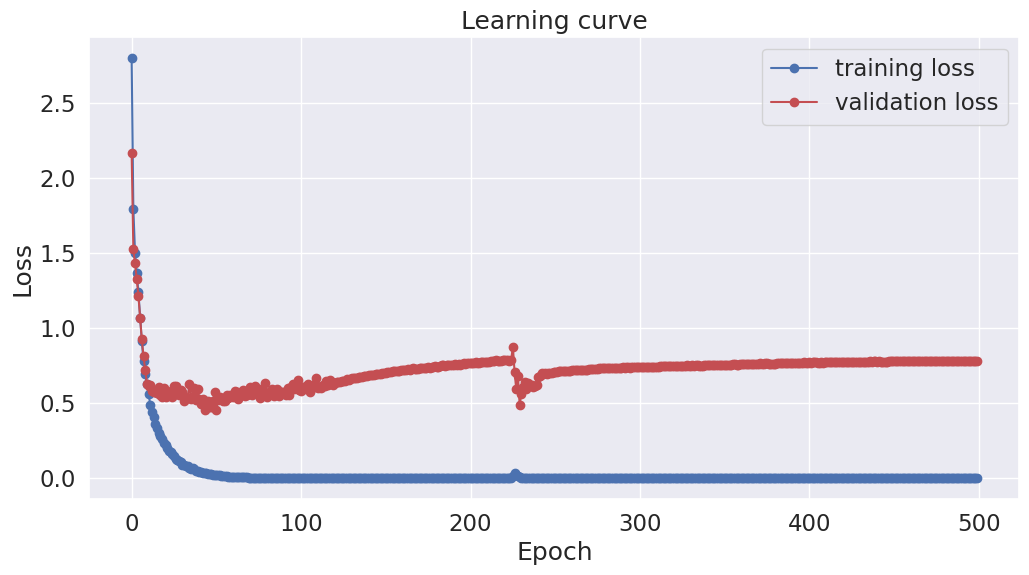

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [23]:
print(test_acc)

[2.1715166568756104, 1.527124007542928, 1.4324417114257812, 1.3278172810872395, 1.2155080636342366, 1.06941952308019, 0.9258046348889669, 0.8134888410568237, 0.7237656911214193, 0.6317276954650879, 0.6155131856600443, 0.6220880647500356, 0.5815864702065786, 0.5762619276841482, 0.5784092048803965, 0.5658537646134695, 0.6070590019226074, 0.5564287602901459, 0.5412672559420267, 0.6043943067391714, 0.5447370310624441, 0.5587717890739441, 0.5535828769207001, 0.5843518972396851, 0.5410084625085195, 0.6149312357107798, 0.6154959400494894, 0.5795712868372599, 0.5581949651241302, 0.5880259275436401, 0.5763143301010132, 0.513219396273295, 0.5377662082513174, 0.53492538134257, 0.6256489157676697, 0.5300913254419962, 0.5516617397467295, 0.5996446510155996, 0.518921305735906, 0.5970652401447296, 0.5304669737815857, 0.494648019472758, 0.5293217400709788, 0.4520951559146245, 0.48699845870335895, 0.5122298995653788, 0.47258300085862476, 0.476227343082428, 0.5182183782259623, 0.5737170974413554, 0.4571

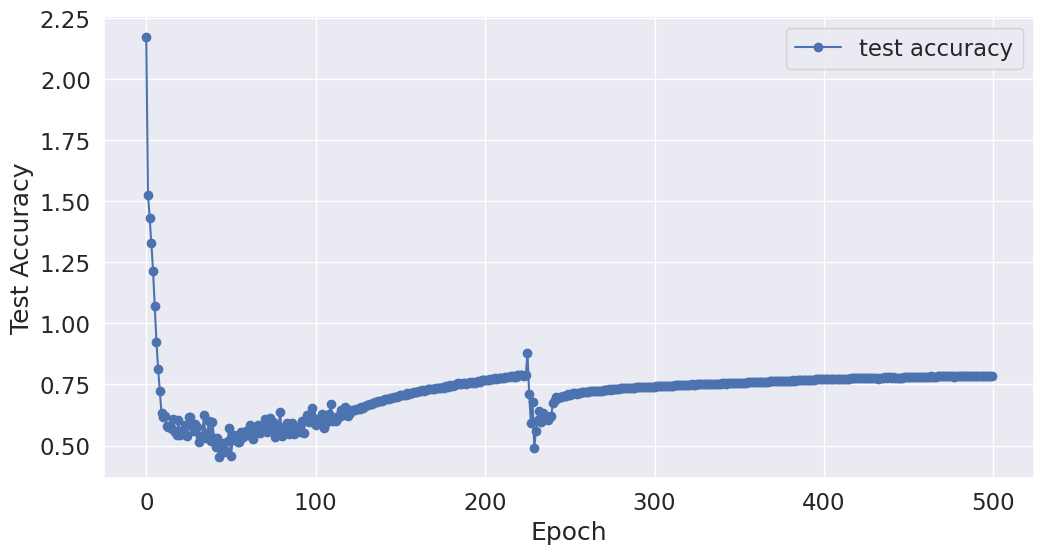

In [24]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(test_acc, 'b-o', label="test accuracy")


# Label the plot.
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()

plt.show()

In [25]:
q = 1
print(acc(False, q))
acc(True, q)


116 0.956989247311828
0.7962446640738706
___________________0___________________

Predict labels:  ['0', '0', 'R', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

___________________25___________________

Predict labels:  ['0', 'C', 'C', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0']
Actual labels:  ['0', '0', 'C', 'C', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0']


___________________26___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', '0', 'C', 'C', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', 'C', 'C', '0', '0', 'M', 'M-cont', '0', '0', 'C', 'C', 'C', '0', '0', 'C', 'C', 'C', '0', '0', '0', '0', '0']
Actual

___________________51___________________

Predict labels:  ['0', '0', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', '0', '0', '0', 'Q', 

___________________77___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', 'A', 'M', 'M', 'M', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', 'M', 'M', '0', 'A', 'A', 'A', 'A', 'A', '0', '0', '0', 'A', '0', 'A', 'A', 'A', '0', '0', 'C', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', 'A', 'M', 'M', 'M', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-

___________________103___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', '0', '0']


___________________104___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0',

___________________128___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0

___________________153___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', 'C', '0', '0', 'T', 'T', 'T', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

0.7962446640738706

In [26]:
print(acc(False, 112))

116 0.956989247311828
0.7962446640738706


In [27]:
model = torch.load("test.ck")
model.eval()

print(acc(False))
print(acc(True))

FileNotFoundError: [Errno 2] No such file or directory: 'test.ck'